In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import numpy.typing as npt

plt.style.use(['science', 'ieee', 'no-latex'])

In [2]:
# constants
ETA = 377
NA = 0.86
LAMBDA = 248           # nm
K = 2 * np.pi / LAMBDA
W = NA / LAMBDA        # pupil width

s_single_space = 1000         # x space
s_single_width = 100          # aperture width
THRESHOLD = 0.4

# sampling rate: cut in a unit
Fs_single = 1000 # error < 0.0001
# Fs_single = 1000 # error < 

In [3]:
s_single = np.linspace(
	-s_single_space, s_single_space, 
	2 * s_single_space * Fs_single + 1, 
	dtype=np.double
)
mask_single = np.where(np.abs(s_single) <= 100, 1, 0)

In [4]:
def generate_Ein(
	s: npt.NDArray,
	angle: int = 0,
	magnitude: int = 1
) -> npt.NDArray:
	angle = angle / 180 * np.pi
	return magnitude * np.exp(1j * K * s * np.sin(angle))

In [5]:
def freq_to_Eout(
	s: npt.NDArray,
	E_out: npt.NDArray,
	Fs: int
):
	N = (s.shape[0] - 1) // 2
	freq = Fs / (2 * N) * np.arange(-N, N + 1)
	E_out_shift = np.concatenate((E_out[N + 1:], E_out[:N + 1]))
	return freq, E_out_shift

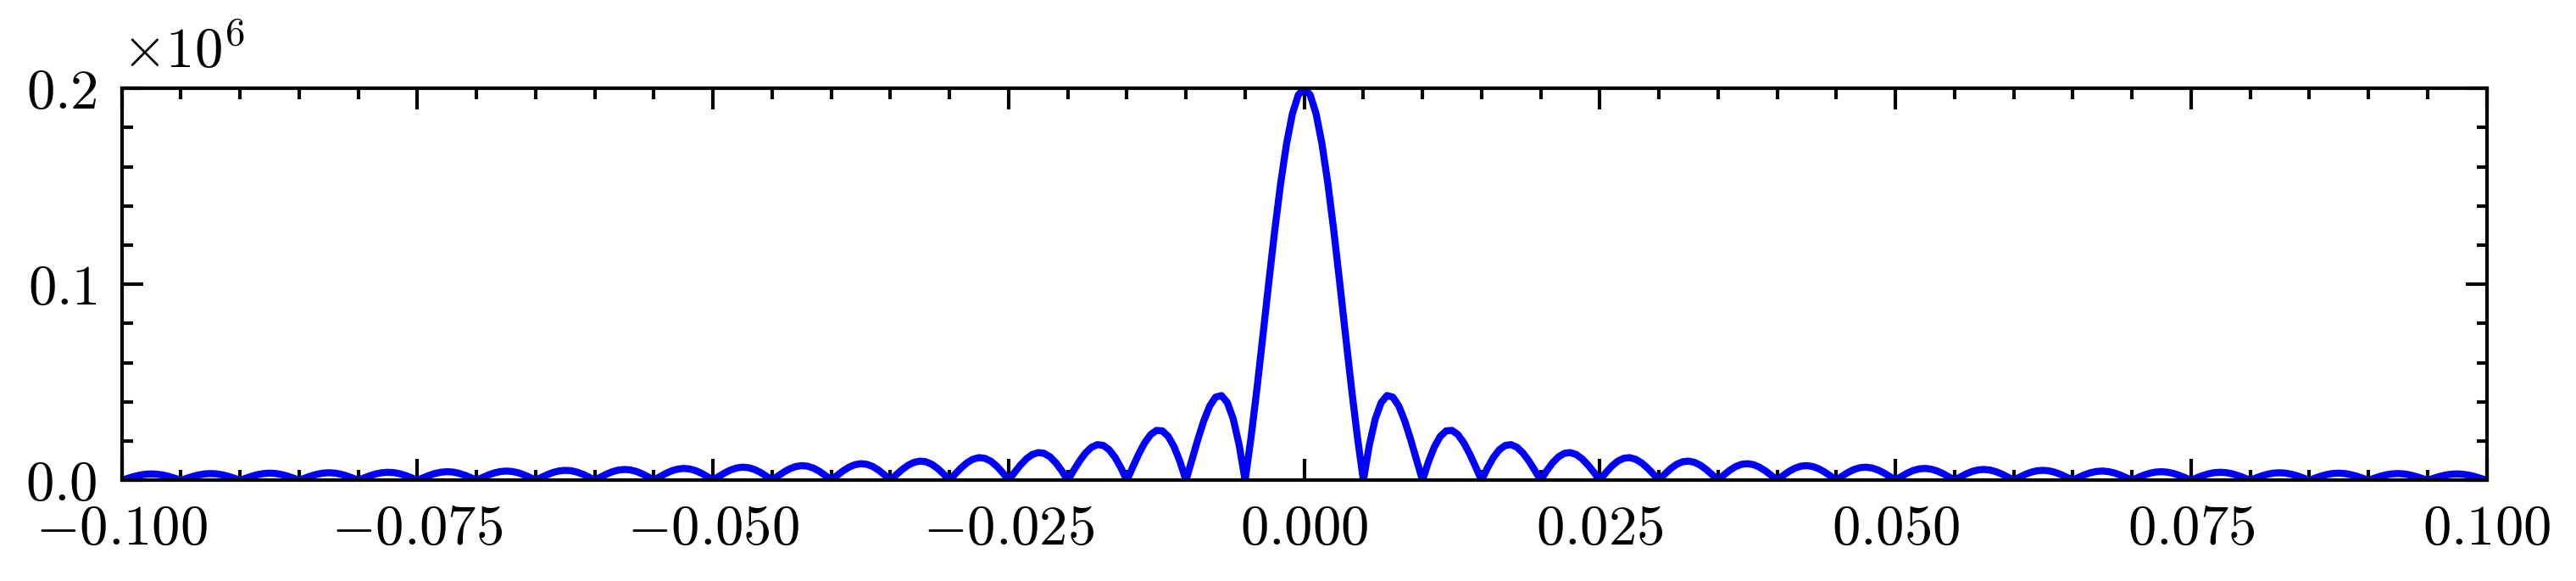

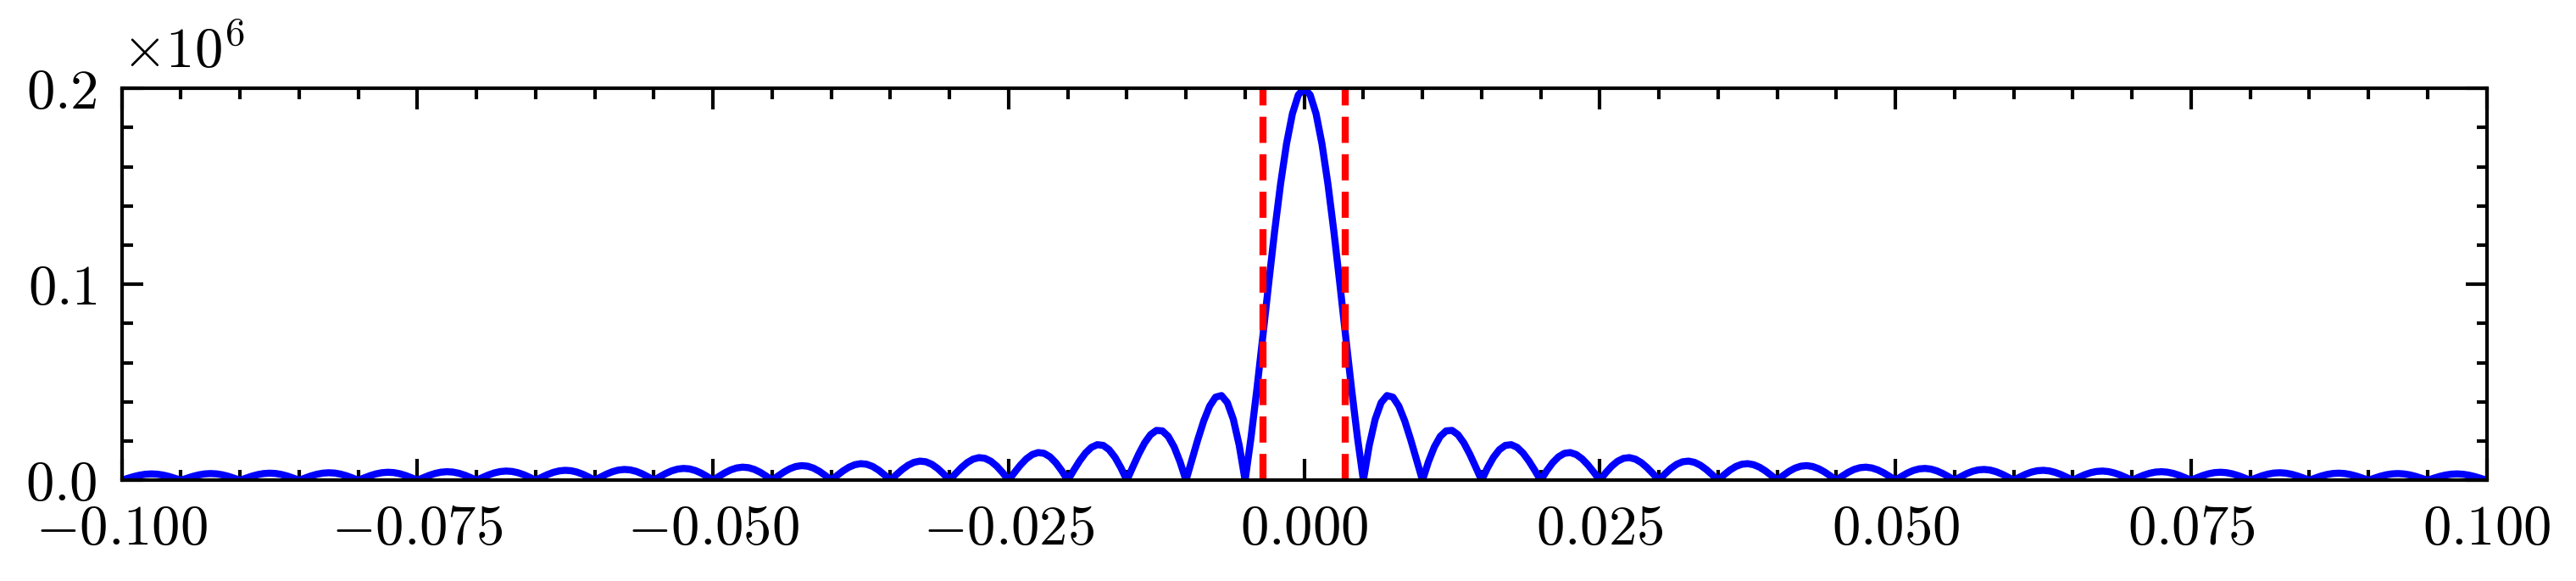

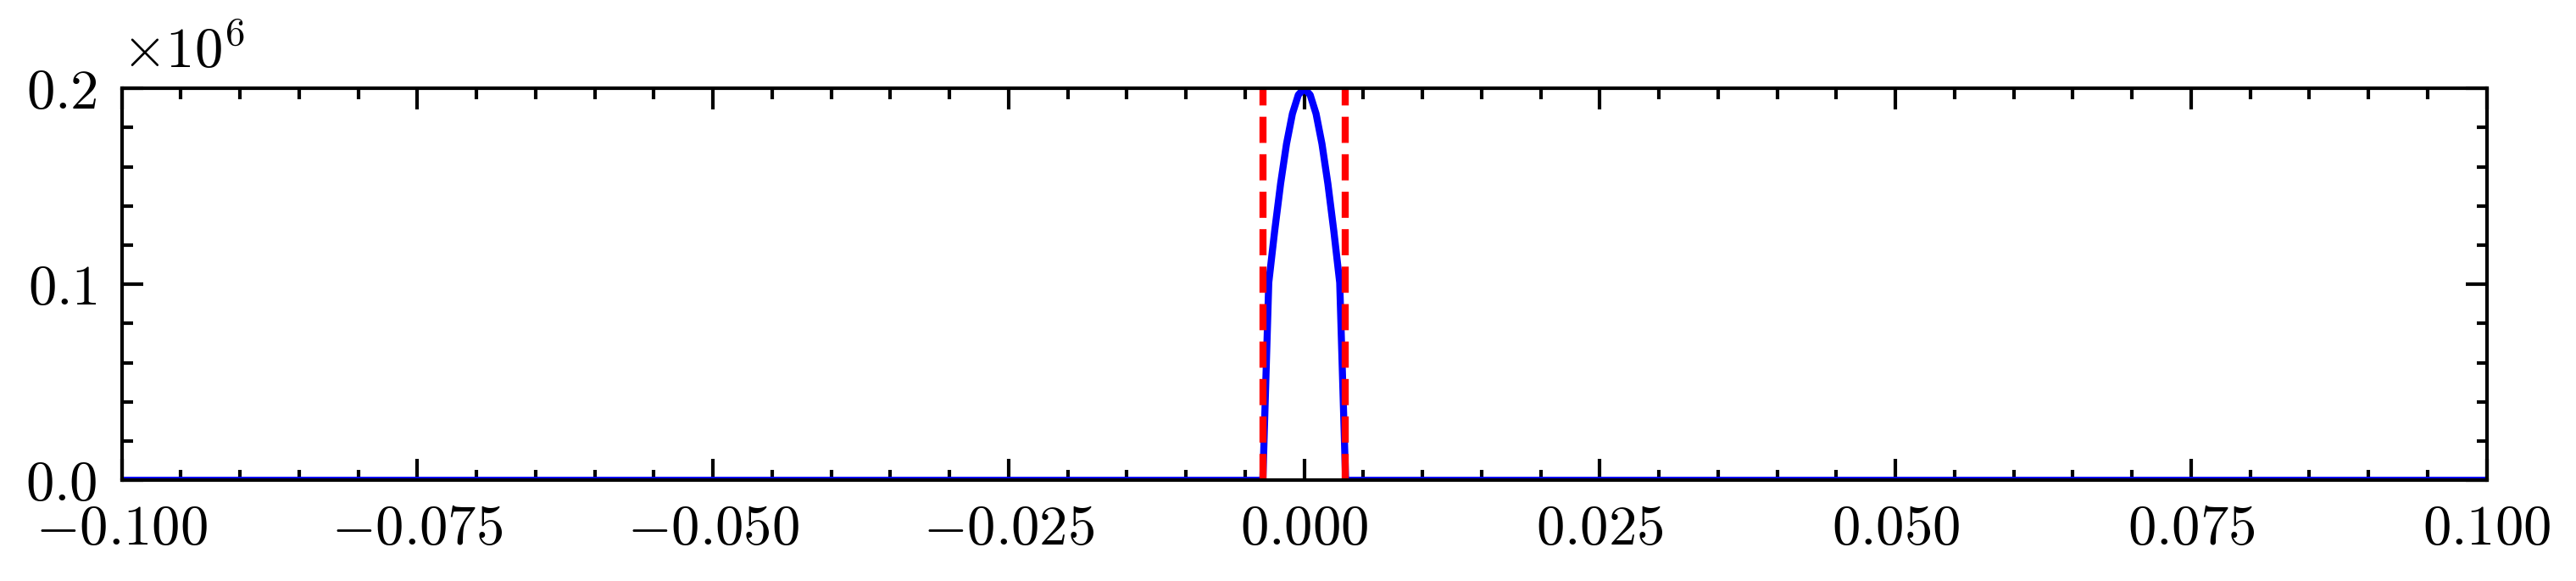

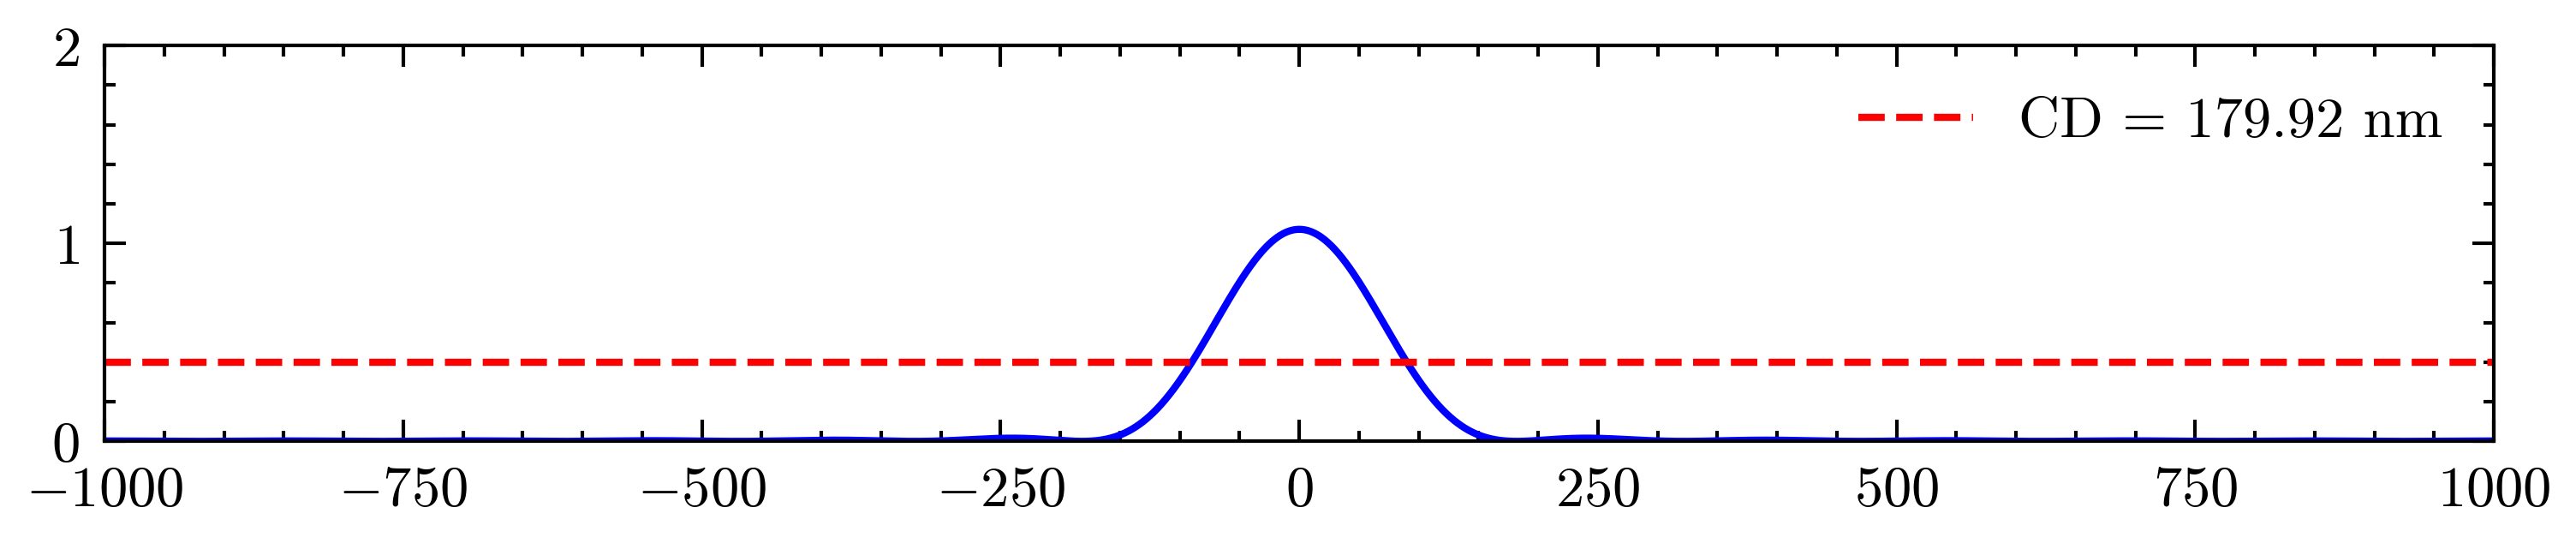

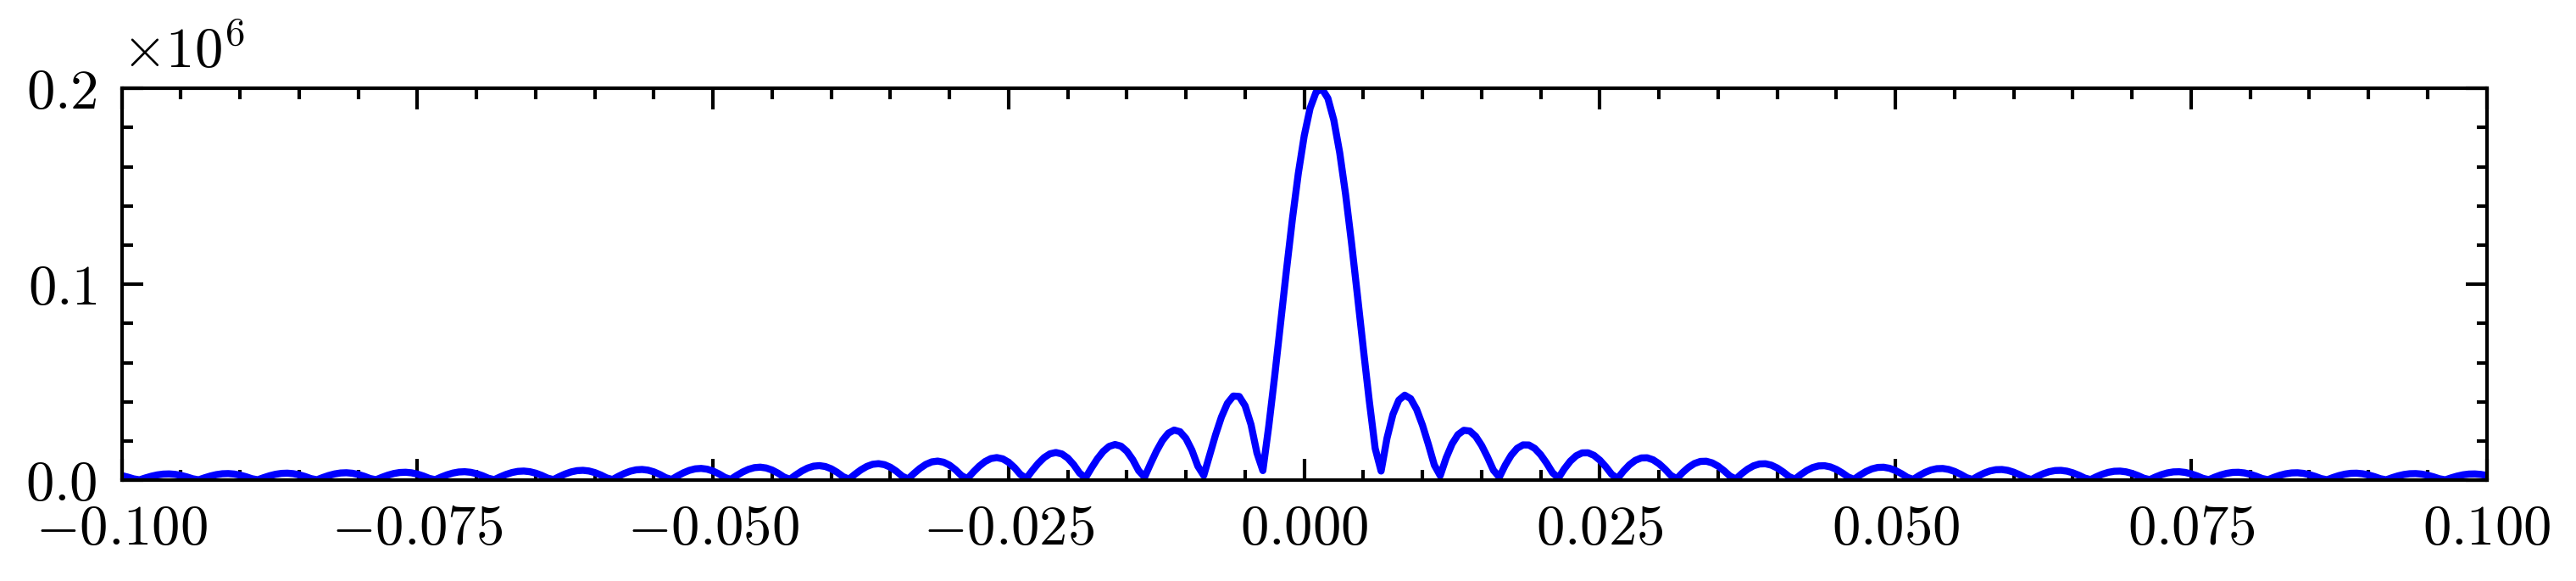

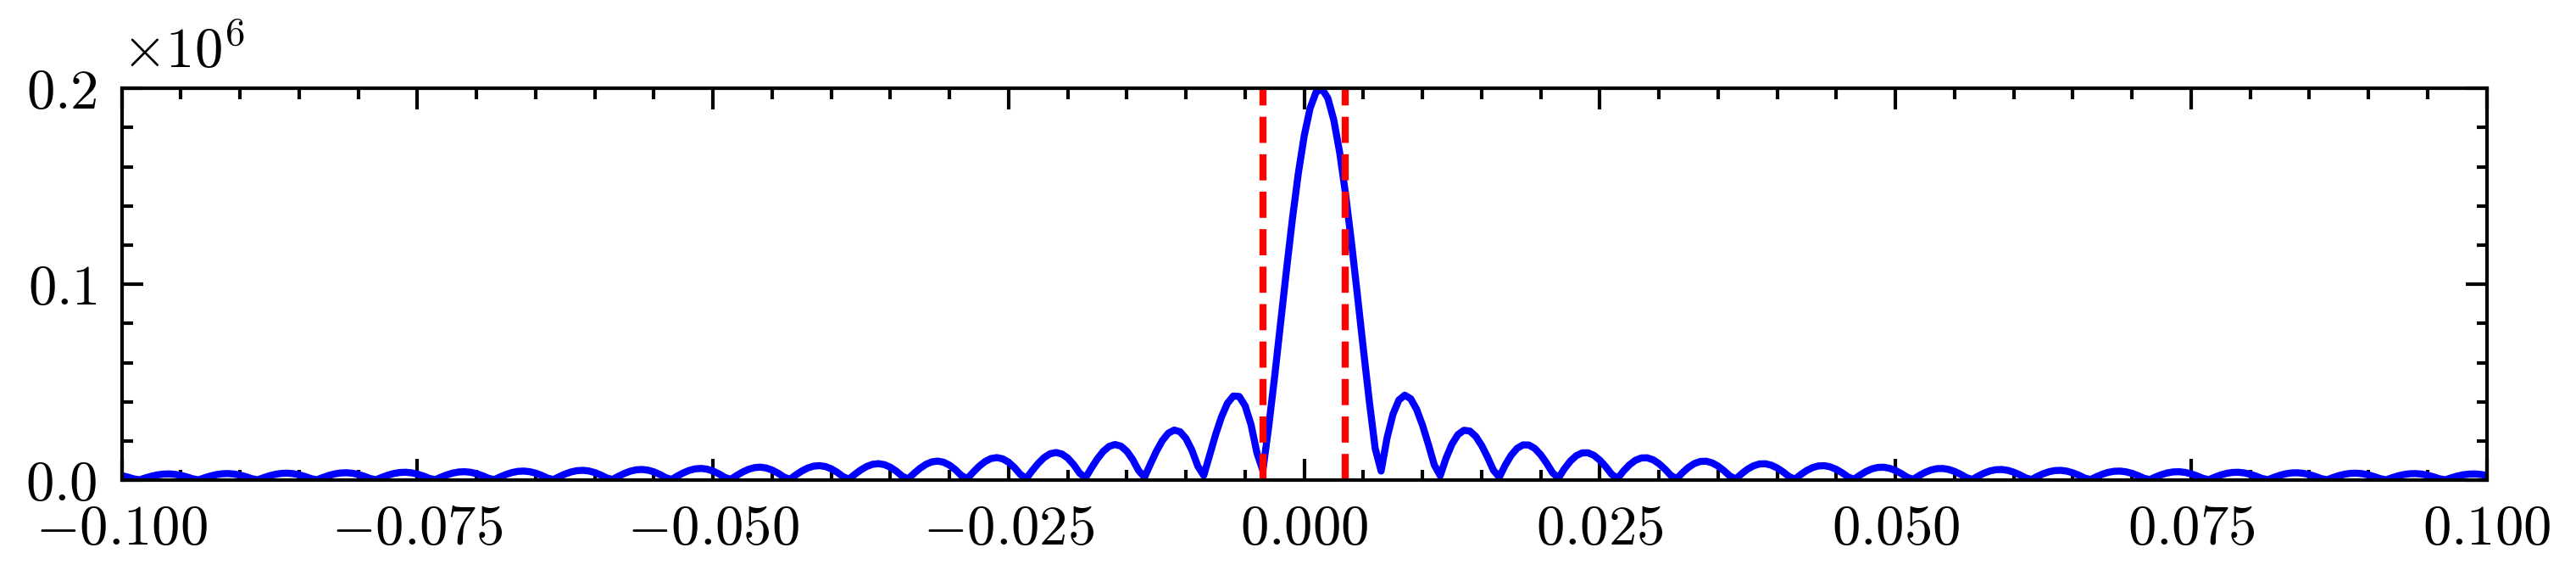

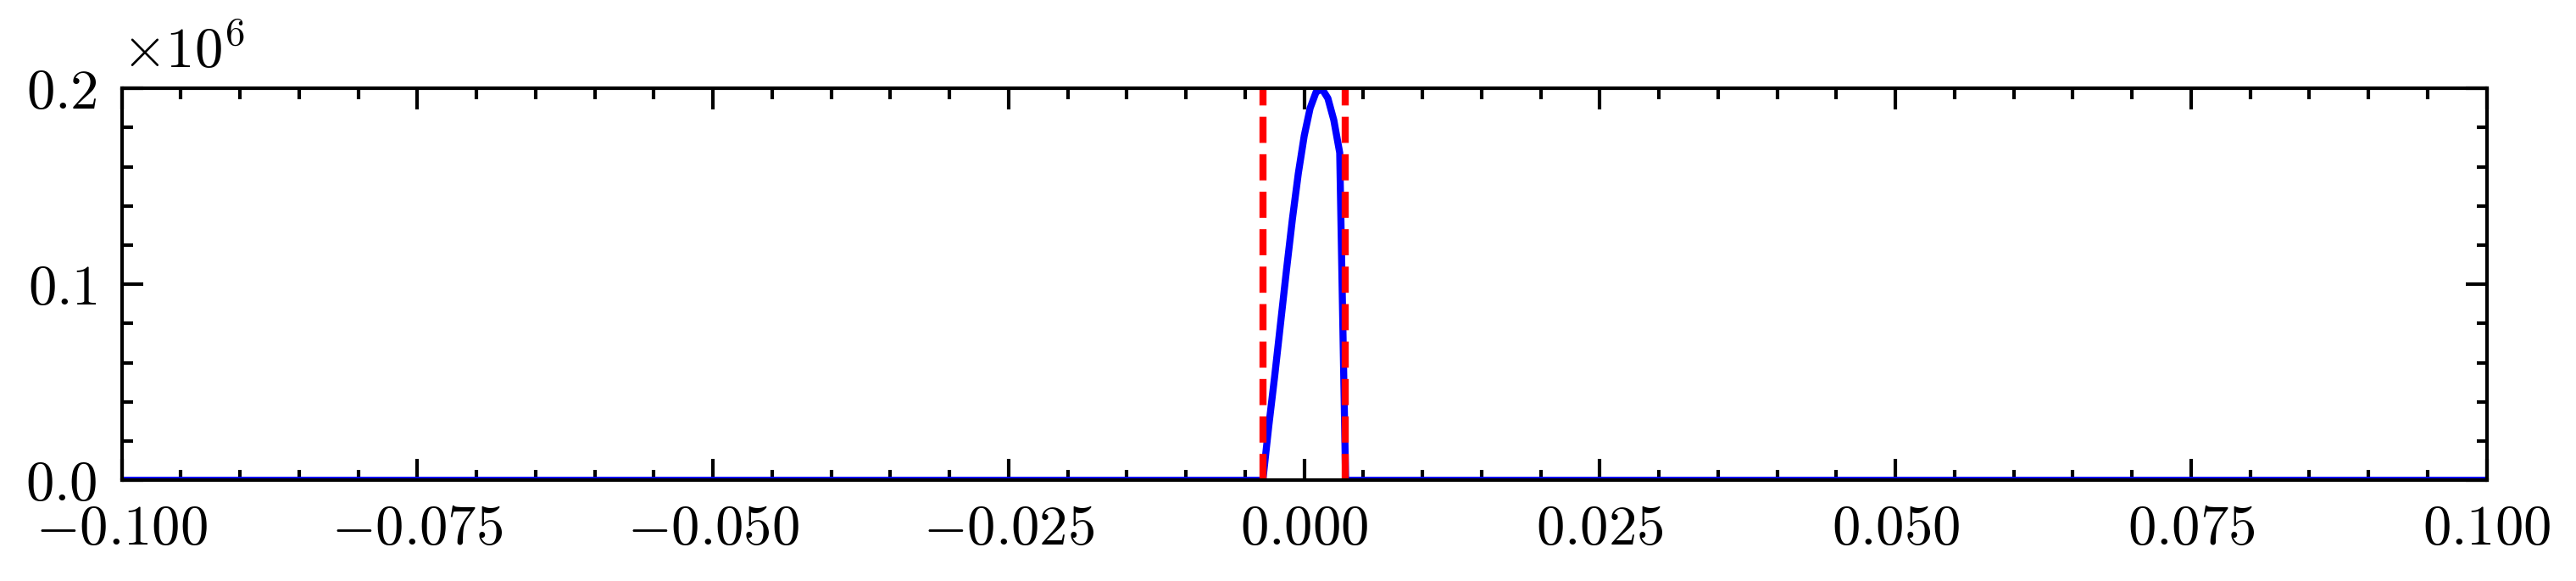

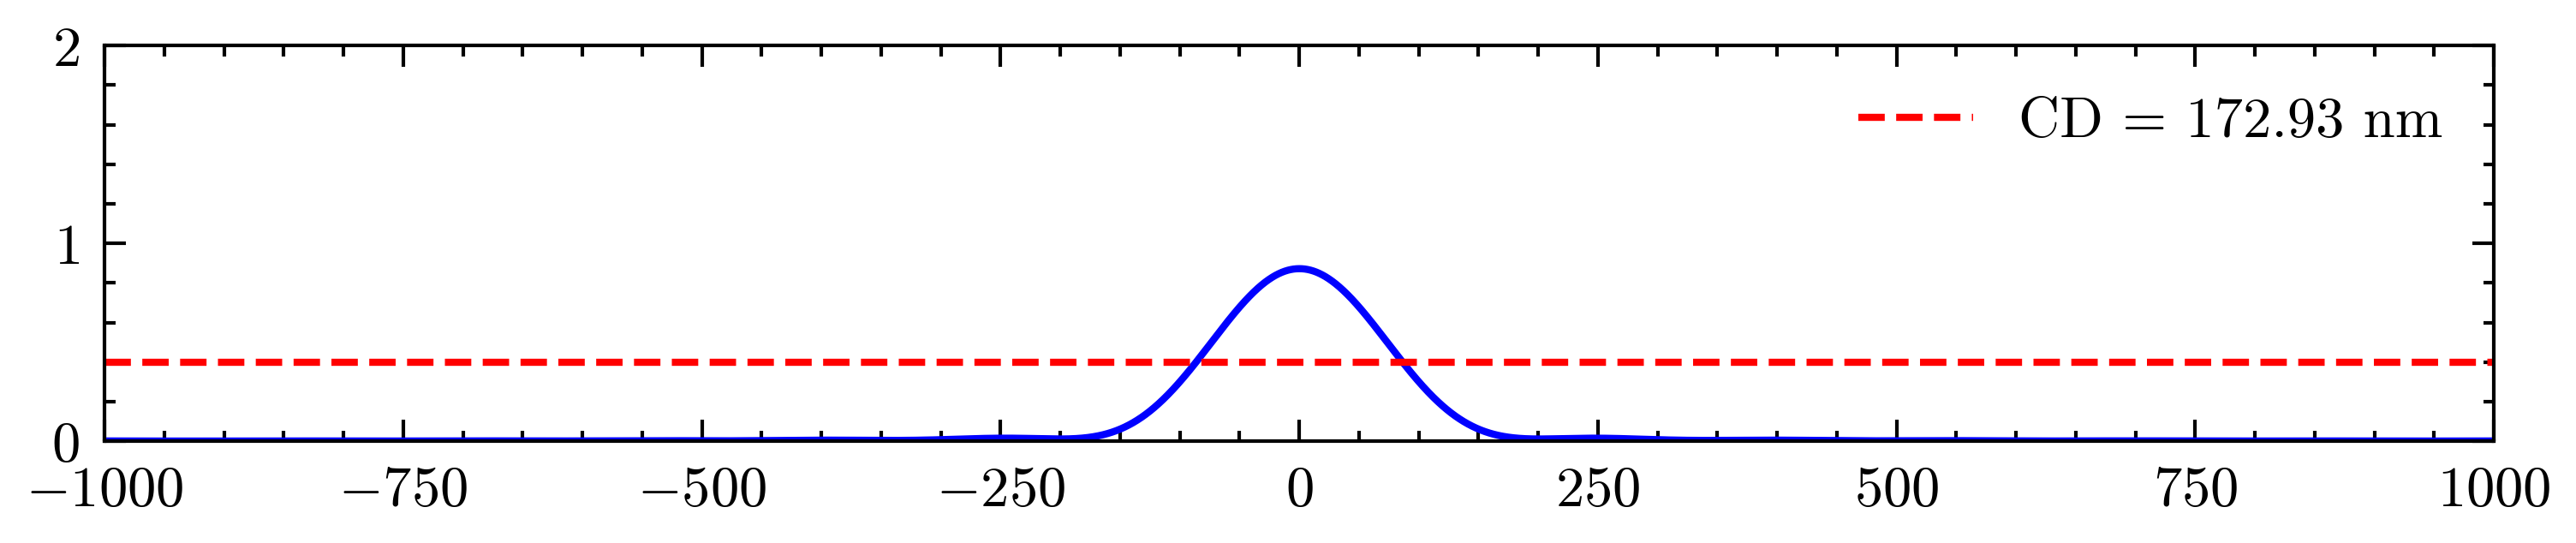

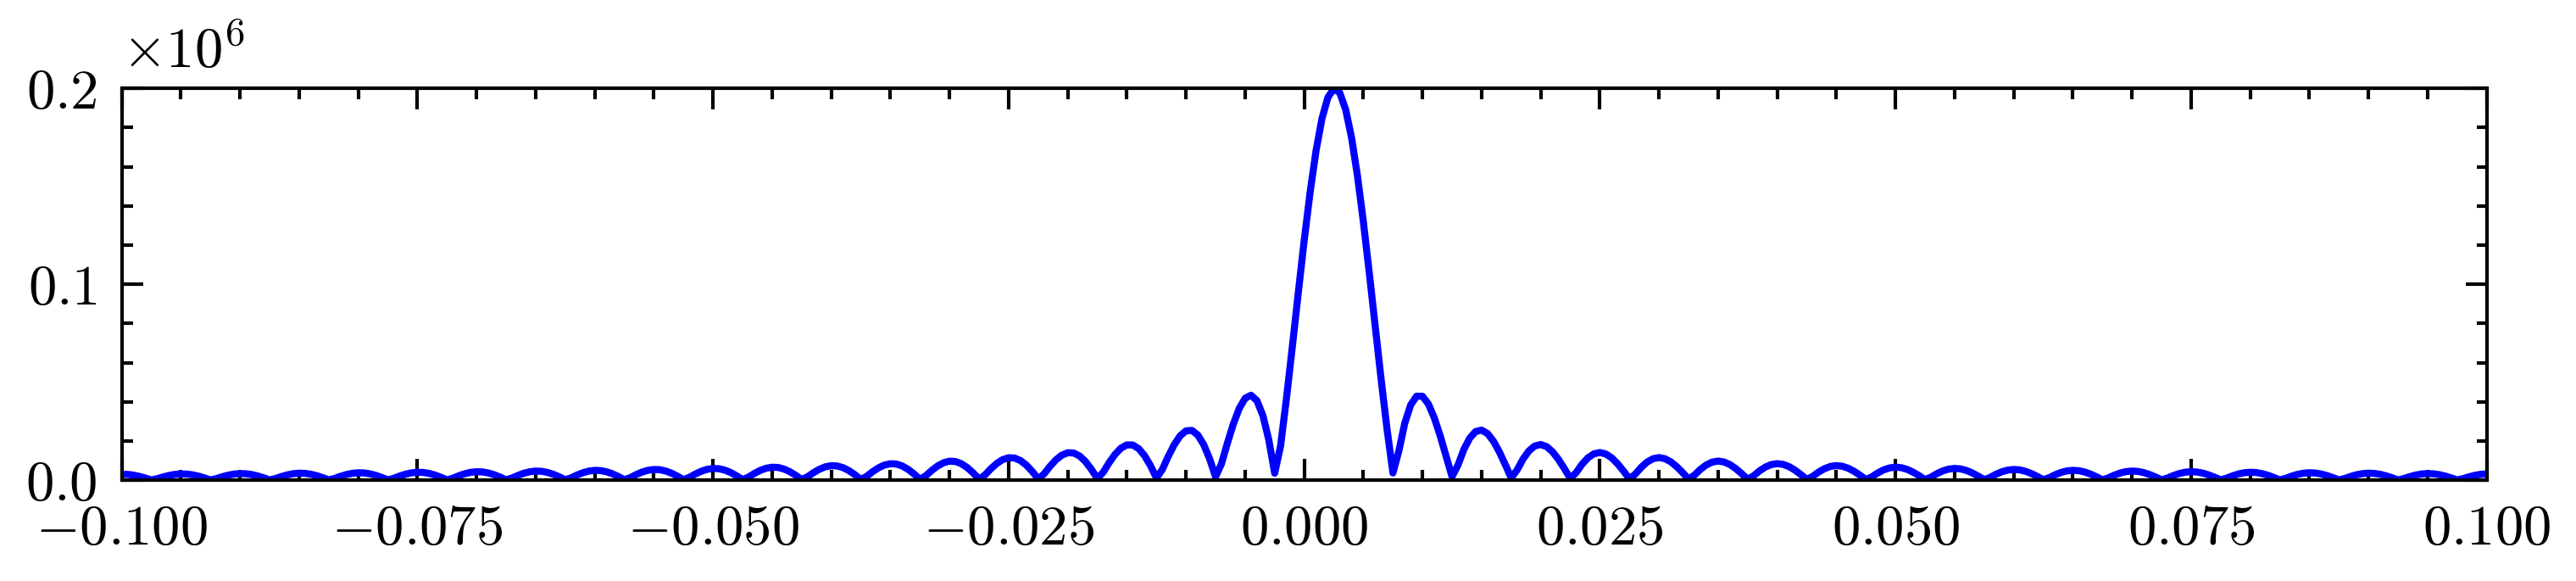

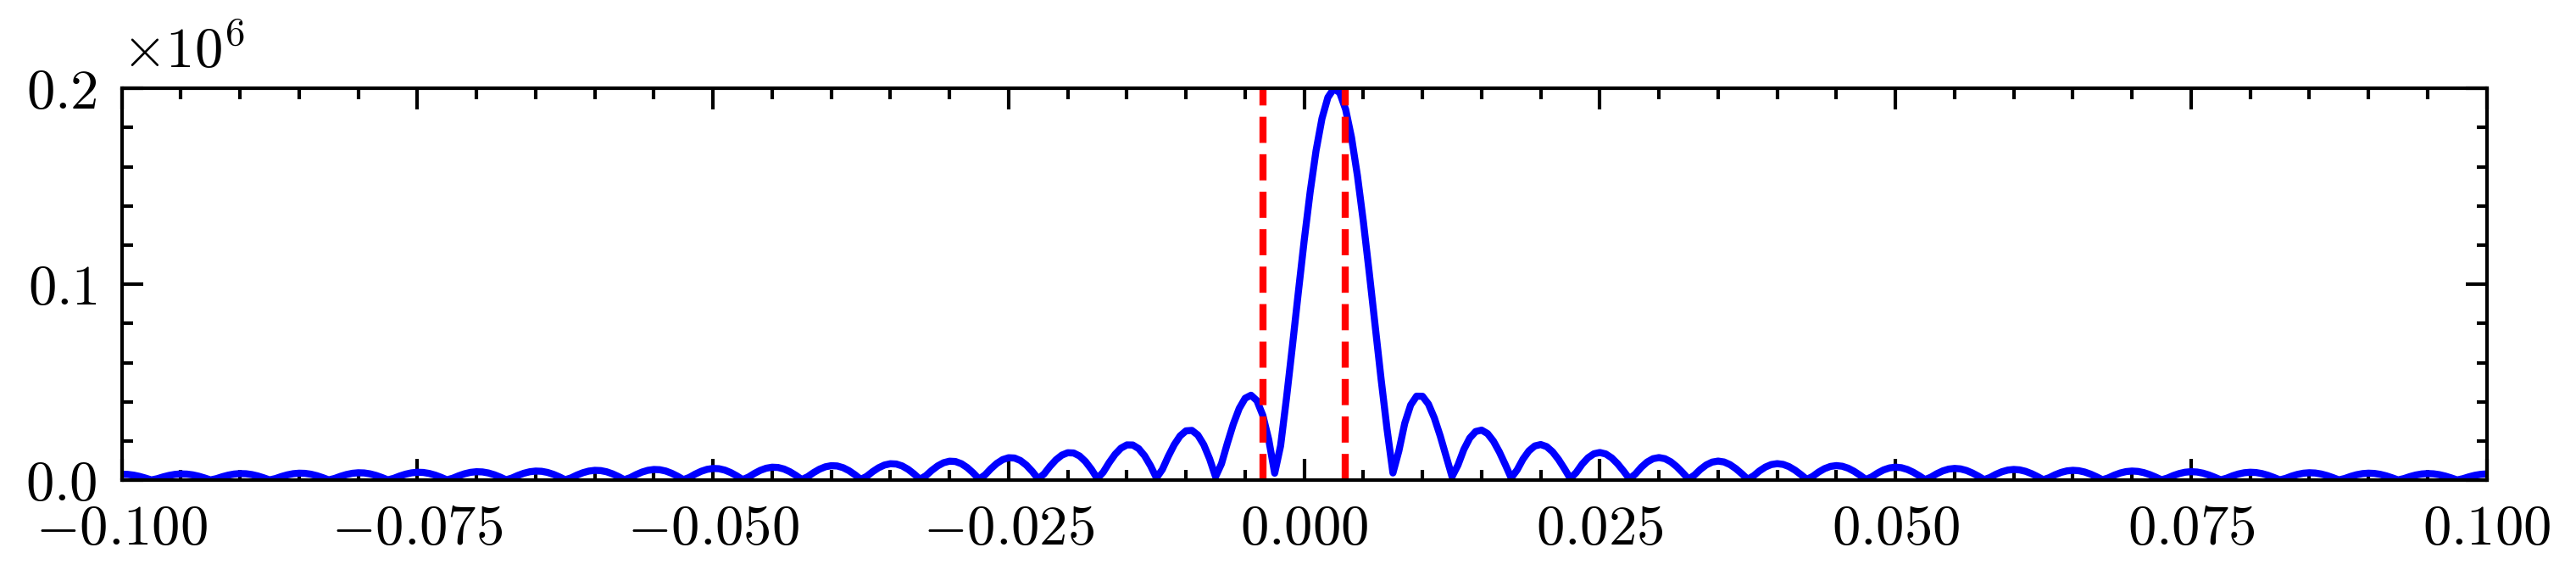

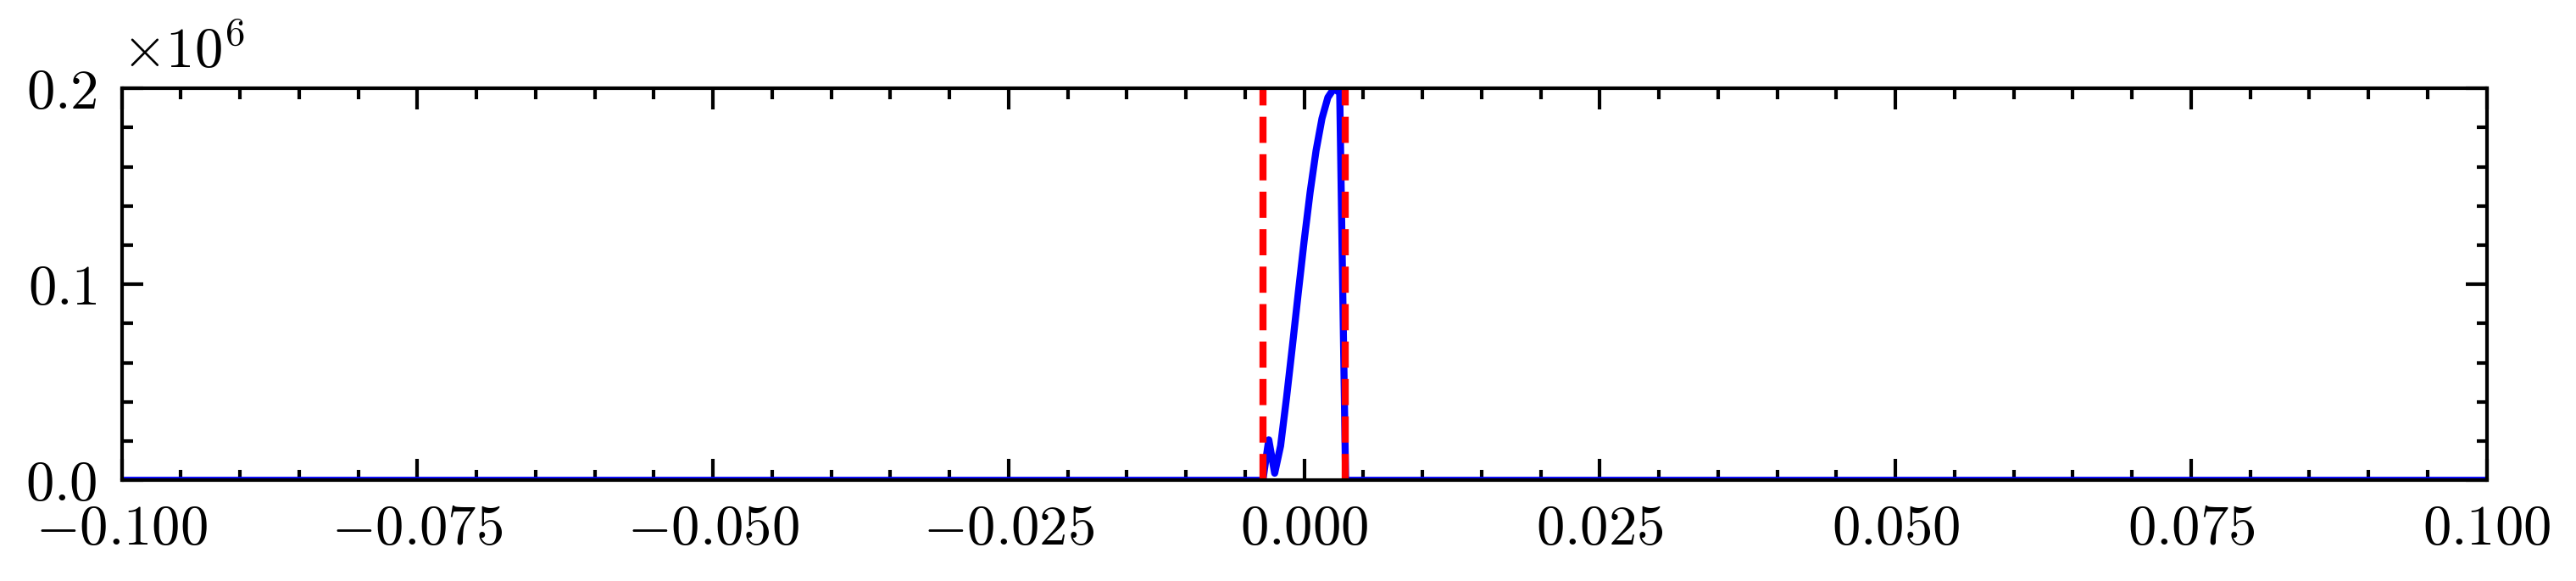

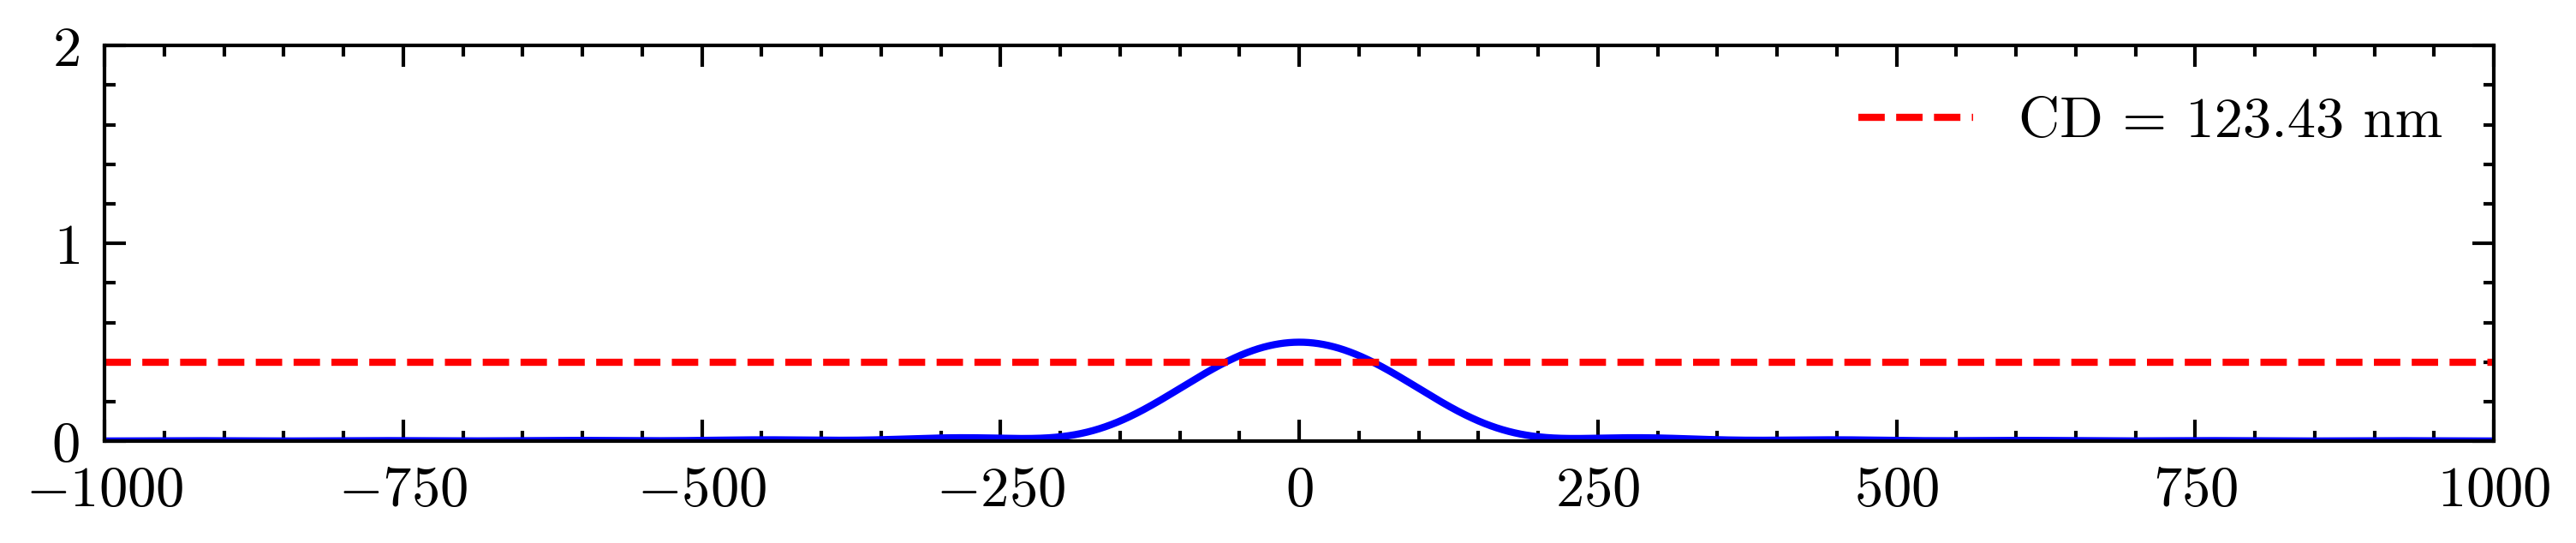

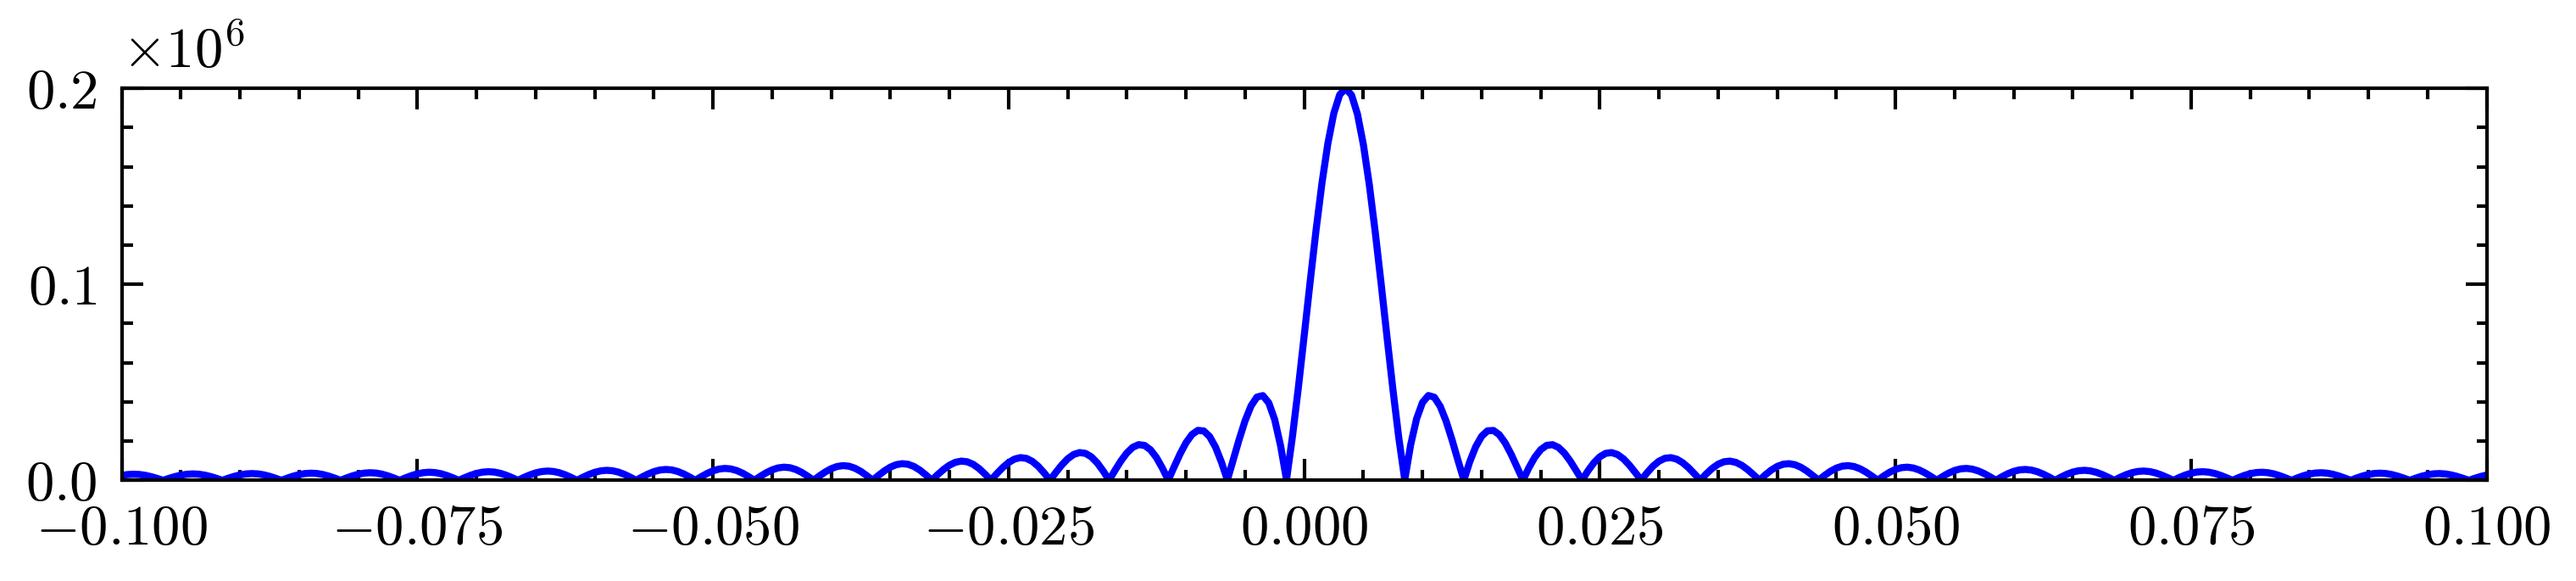

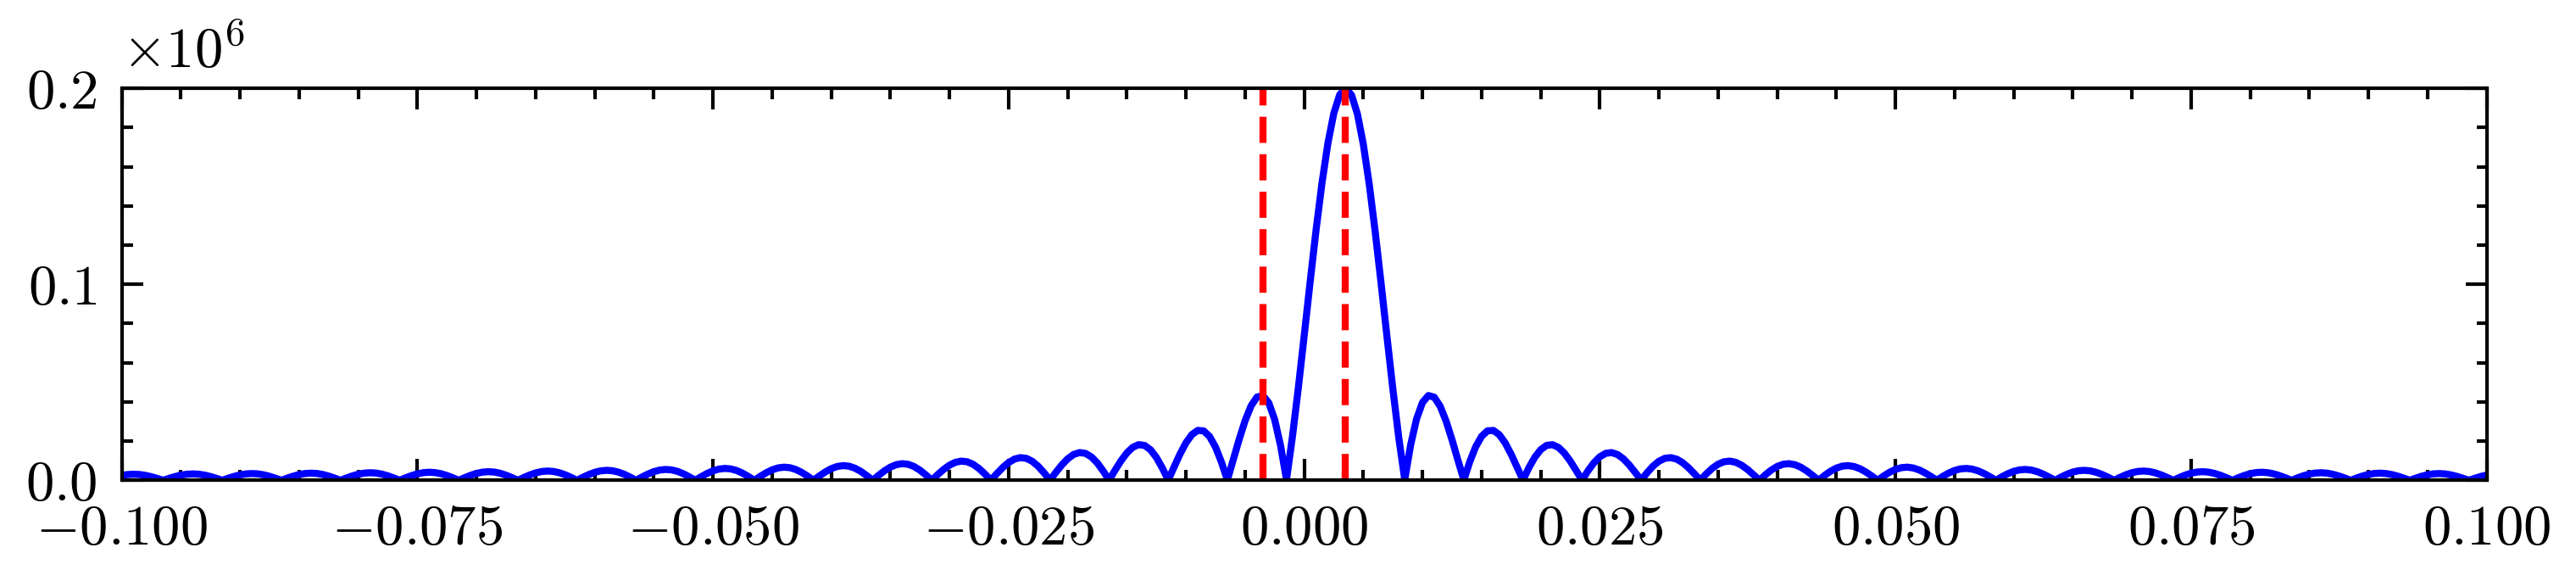

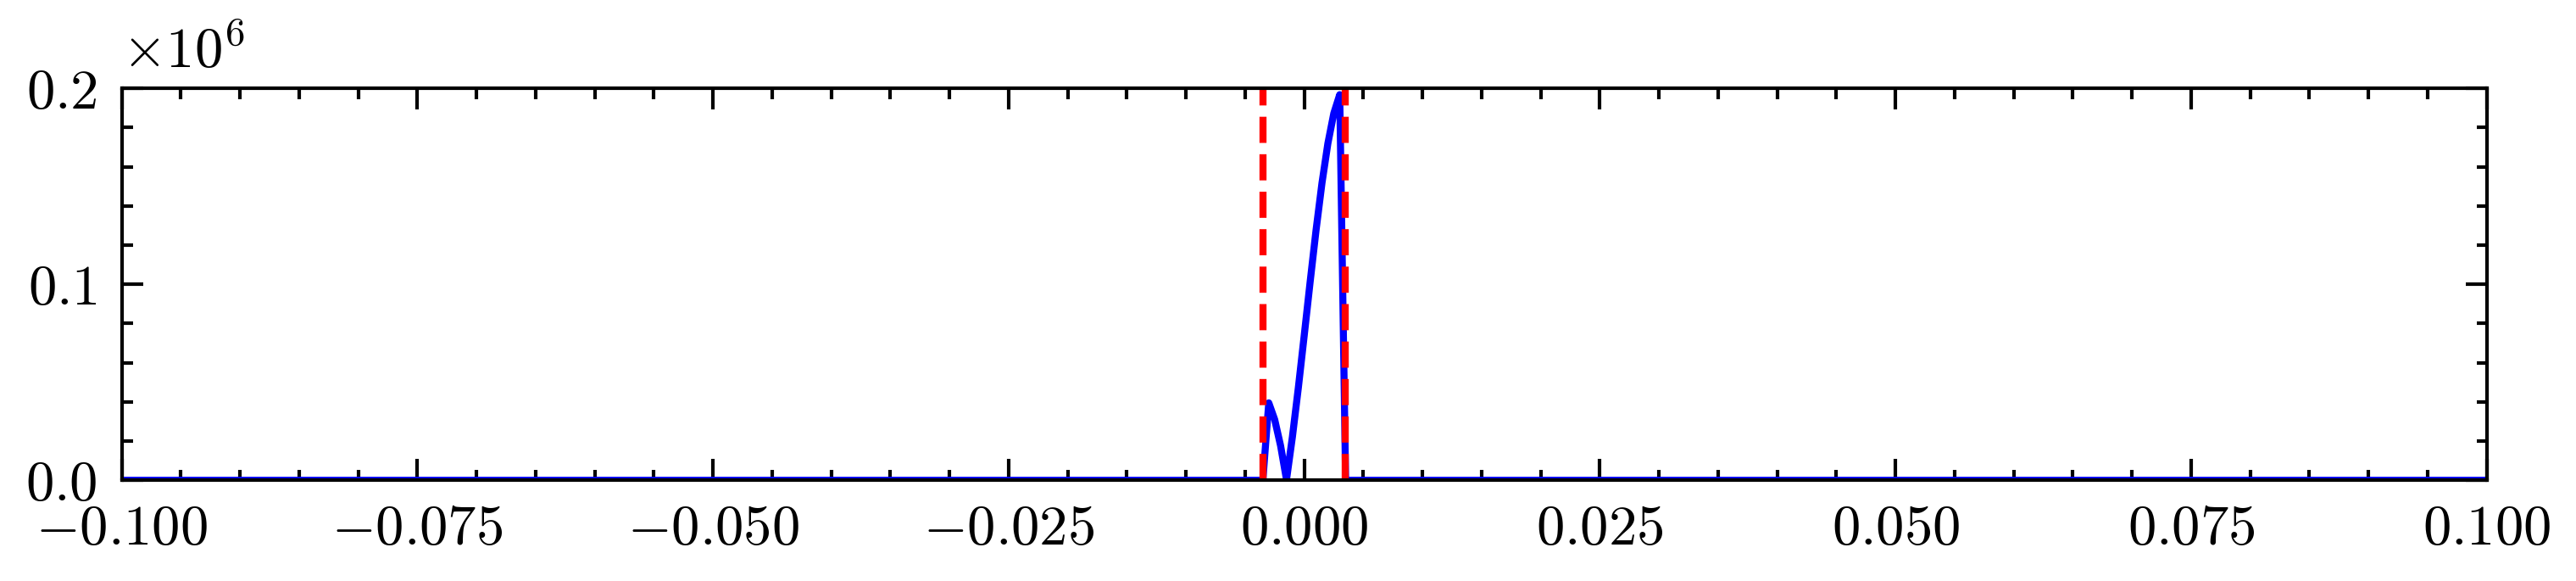

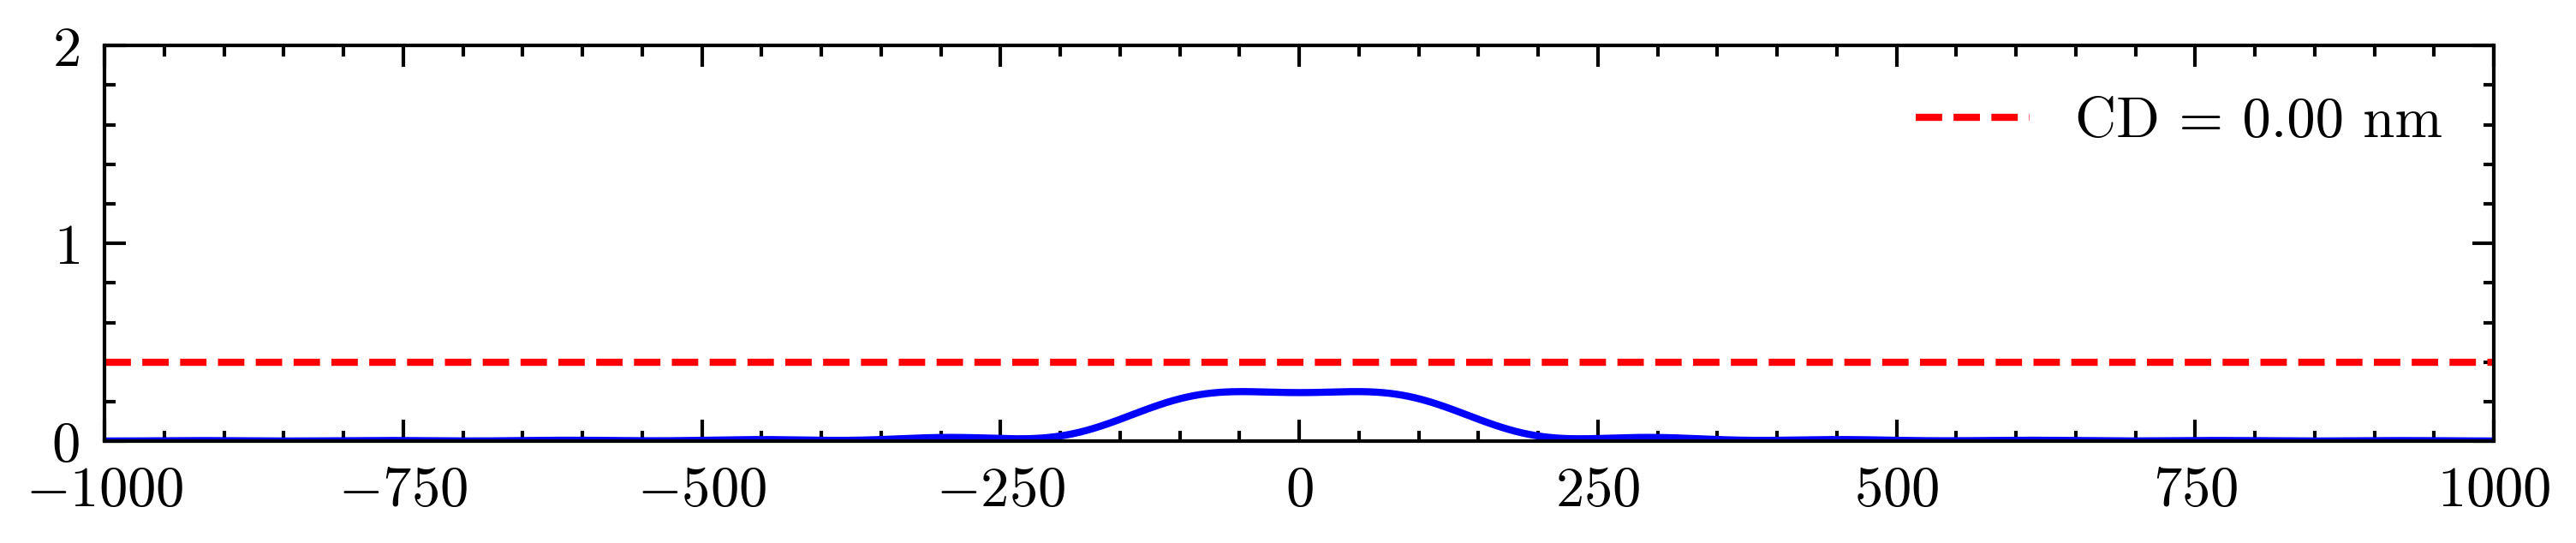

In [6]:
# single slit with different angles
thetas = [0, 20, 40, 60]
magnitude = 1
y_max = 2 * s_single_width * Fs_single * magnitude
for angle in thetas:
	# generate Ein
	E_in = generate_Ein(s_single, angle, magnitude)
	# Ein and the mask
	E_in_mask = np.multiply(E_in, mask_single)
	# generate Eout
	E_out_unshift = np.fft.fft(E_in_mask)
	# get freq, Eout
	freq, E_out_shift = freq_to_Eout(
		s_single,
		E_out_unshift,
		Fs_single
	)

	# condition specified frequency region
	cond = np.abs(freq) <= 0.1
	# plot the frequency to E_out_shift
	plt.figure(figsize=(6, 1))
	plt.xlim(-0.1, 0.1)
	plt.ylim(0, y_max)
	plt.ticklabel_format(
		axis='y', 
		style='sci', 
		scilimits=(6, 6)
	)
	plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
	plt.savefig(f'img_retry/single_slit_FT_{(angle // 20) + 1}')

	# plot the cut-off region before exit pupil
	plt.figure(figsize=(6, 1))
	plt.xlim(-0.1, 0.1)
	plt.ylim(0, y_max)
	plt.ticklabel_format(
		axis='y', 
		style='sci', 
		scilimits=(6, 6)
	)
	plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
	plt.axvline(
		x=-W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.axvline(
		x=W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.savefig(f'img_retry/single_slit_FT_cutoff_{(angle // 20) + 1}')

	# after exit pupil
	E_out_shift_after_exit_pupil = np.where(
		np.abs(freq) <= W, E_out_shift, 0
	)
	# plot the cut-off region after exit pupil
	plt.figure(figsize=(6, 1))
	plt.xlim(-0.1, 0.1)
	plt.ylim(0, y_max)
	plt.ticklabel_format(
		axis='y', 
		style='sci', 
		scilimits=(6, 6)
	)
	plt.plot(freq[cond], np.abs(E_out_shift_after_exit_pupil[cond]), 'b-')
	plt.axvline(
		x=-W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.axvline(
		x=W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.savefig(f'img_retry/single_slit_cutoff_{(angle // 20) + 1}')

	# plot the aerial image
	E_output = np.fft.ifft(E_out_shift_after_exit_pupil)
	I = np.multiply(np.abs(E_output), np.abs(E_output))
	try:
		freq_left = np.min(s_single[I >= THRESHOLD])
		freq_right = np.max(s_single[I >= THRESHOLD])
		CD = freq_right - freq_left
	except ValueError:
		CD = 0
	plt.figure(figsize=(6, 1))
	plt.xlim(-s_single_space, s_single_space)
	plt.ylim(0, 2)
	plt.plot(s_single, I, 'b-')
	plt.axhline(THRESHOLD, color='r', linestyle='--', label=f'CD = {CD:.2f} nm')
	plt.legend()
	plt.savefig(f'img_retry/single_slit_aerial_{(angle // 20) + 1}')

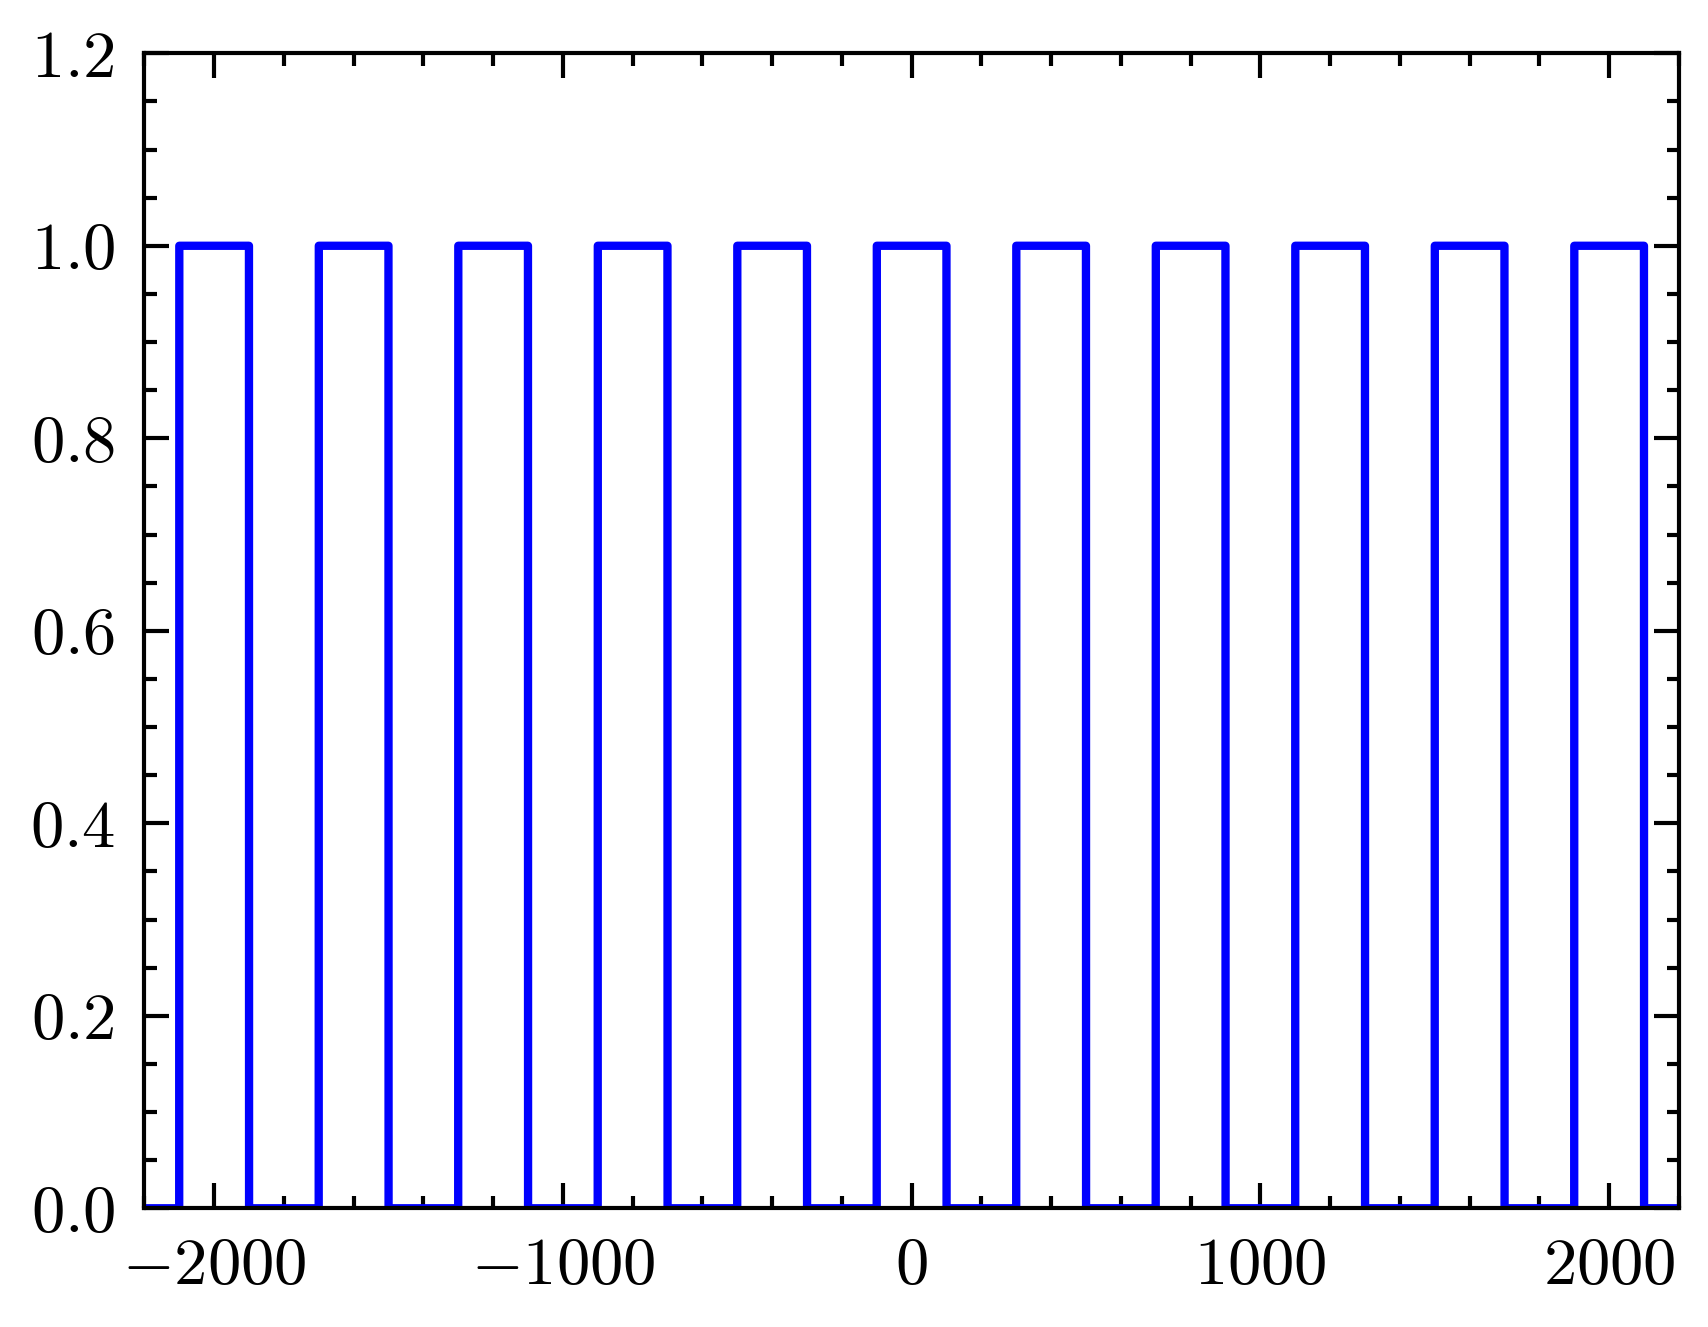

In [7]:
s_dense_space = 2200
s_dense_width = 200
Fs_dense = 100
dense_half = s_dense_width // 2
s_dense = np.linspace(
	-s_dense_space, s_dense_space, 
	2 * s_dense_space * Fs_dense + 1, 
	dtype=np.double
)
mask_dense = np.zeros_like(s_dense, dtype=np.double)
mask_range = range(0, s_dense_space, 2 * s_dense_width)
for center in mask_range:
	cond = np.abs(s_dense - center) <= dense_half
	mask_dense[cond] = 1
	cond = np.abs(s_dense + center) <= dense_half
	mask_dense[cond] = 1

plt.xlim(-s_dense_space, s_dense_space)
plt.ylim(0, 1.2)
plt.plot(s_dense, mask_dense, 'b-')

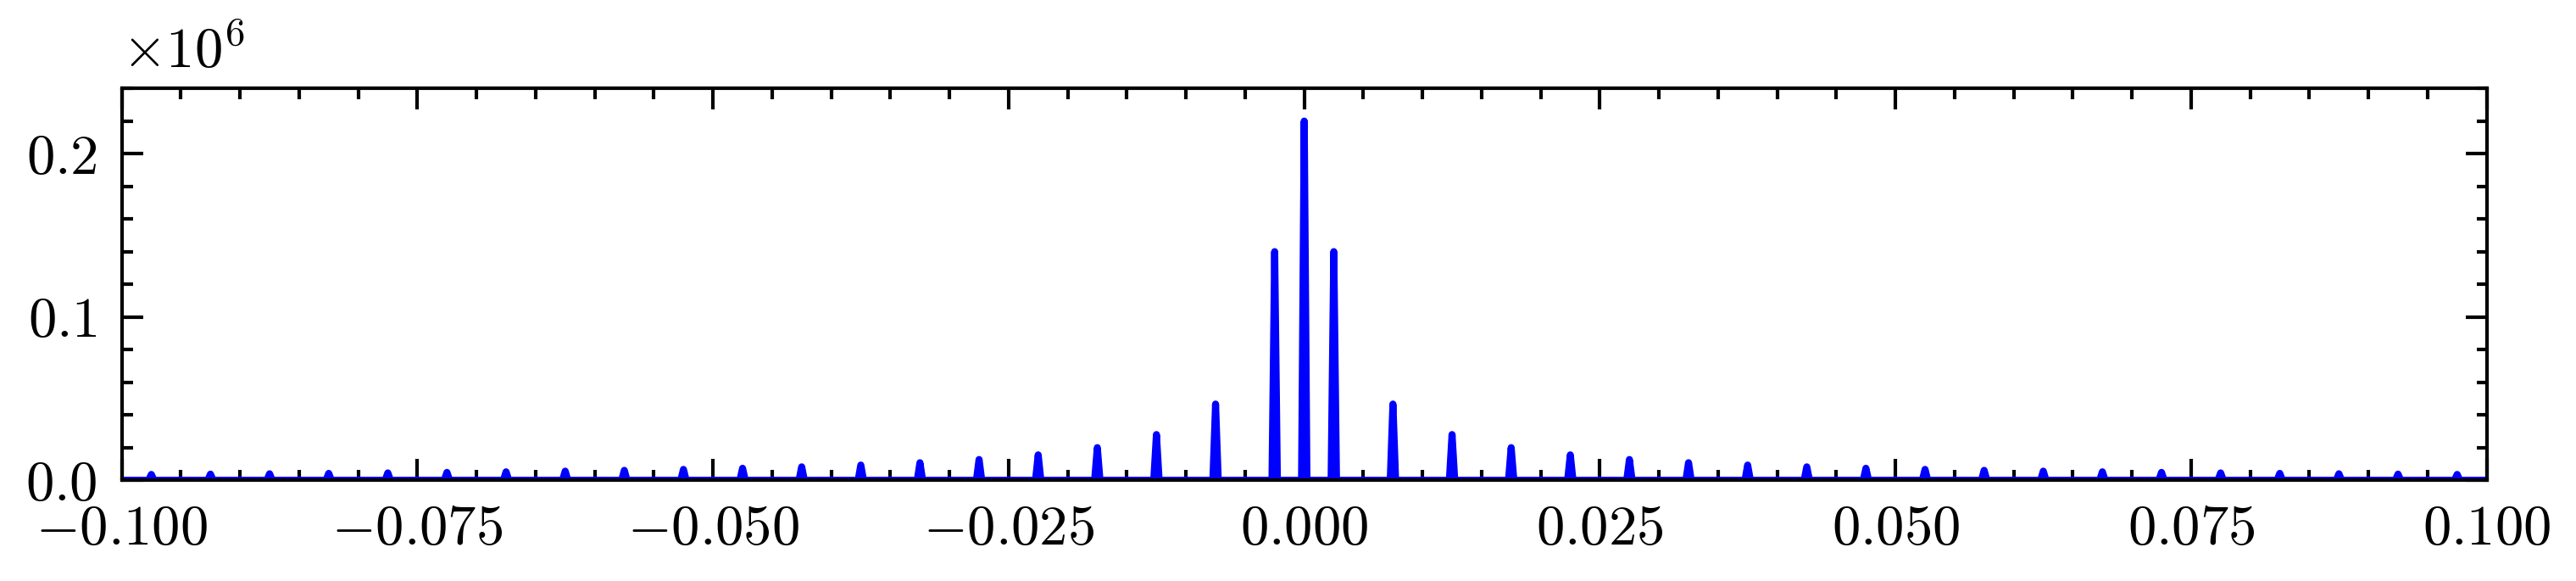

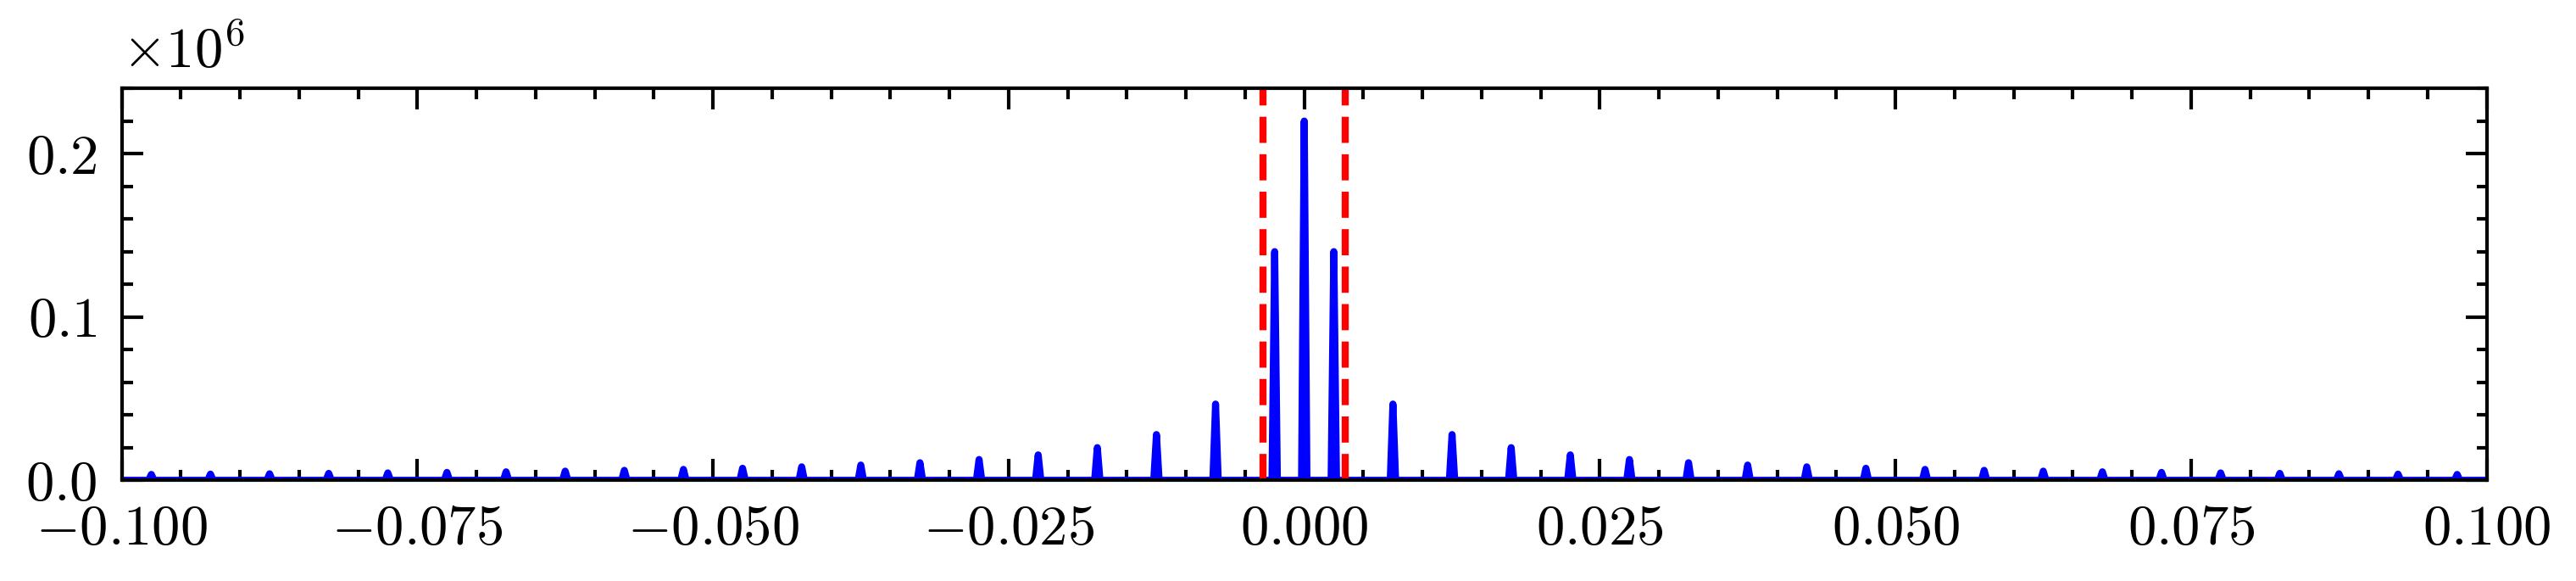

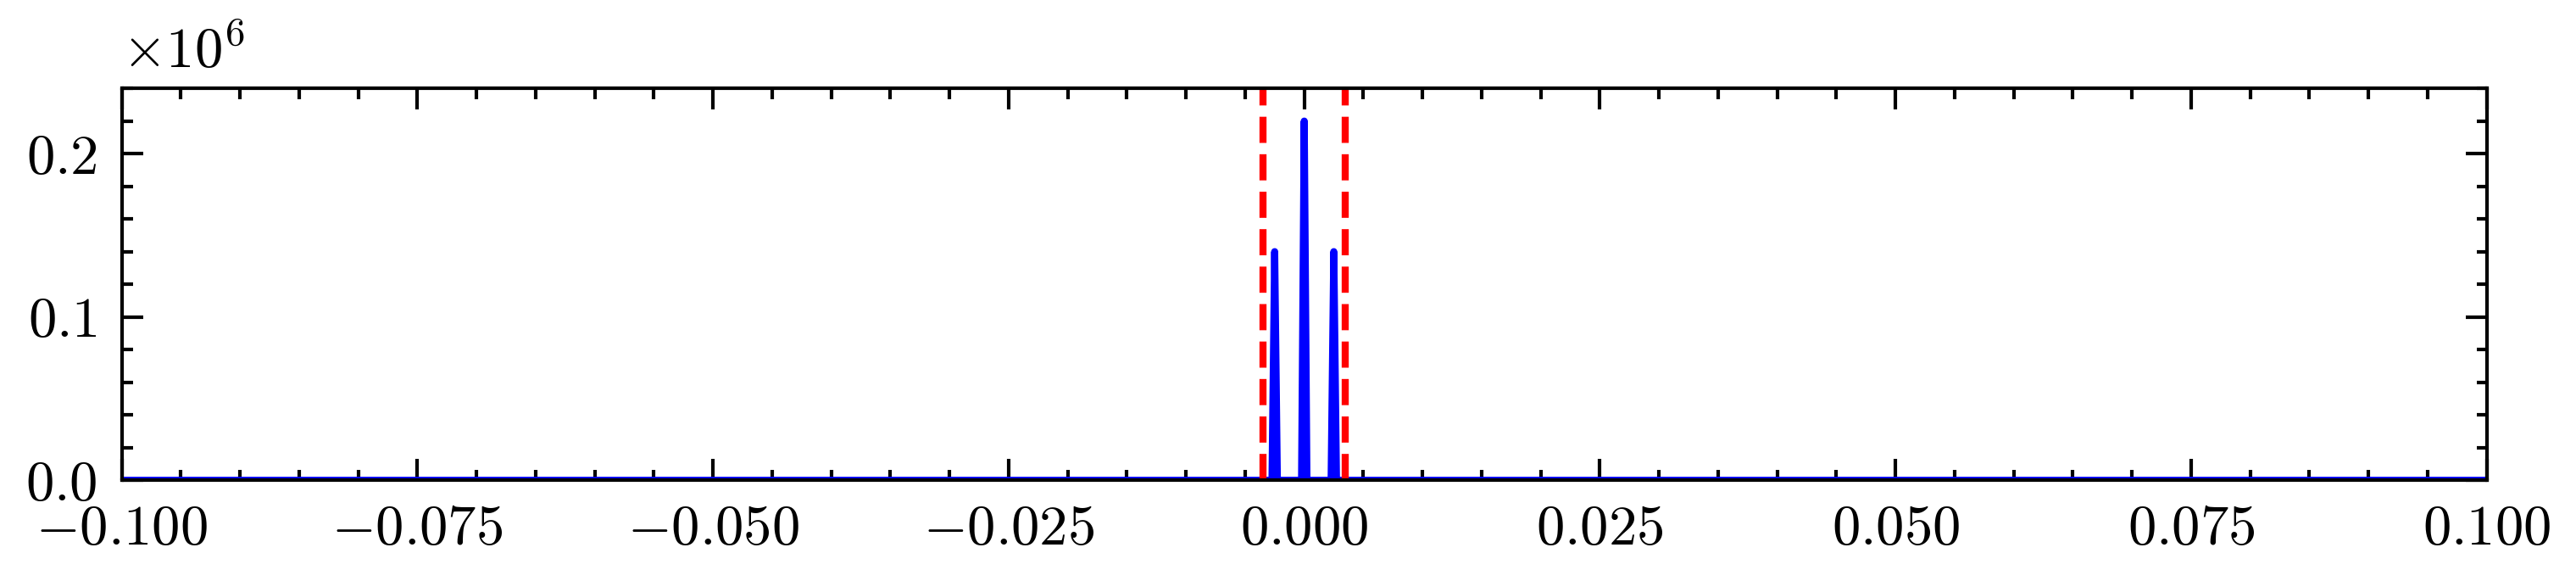

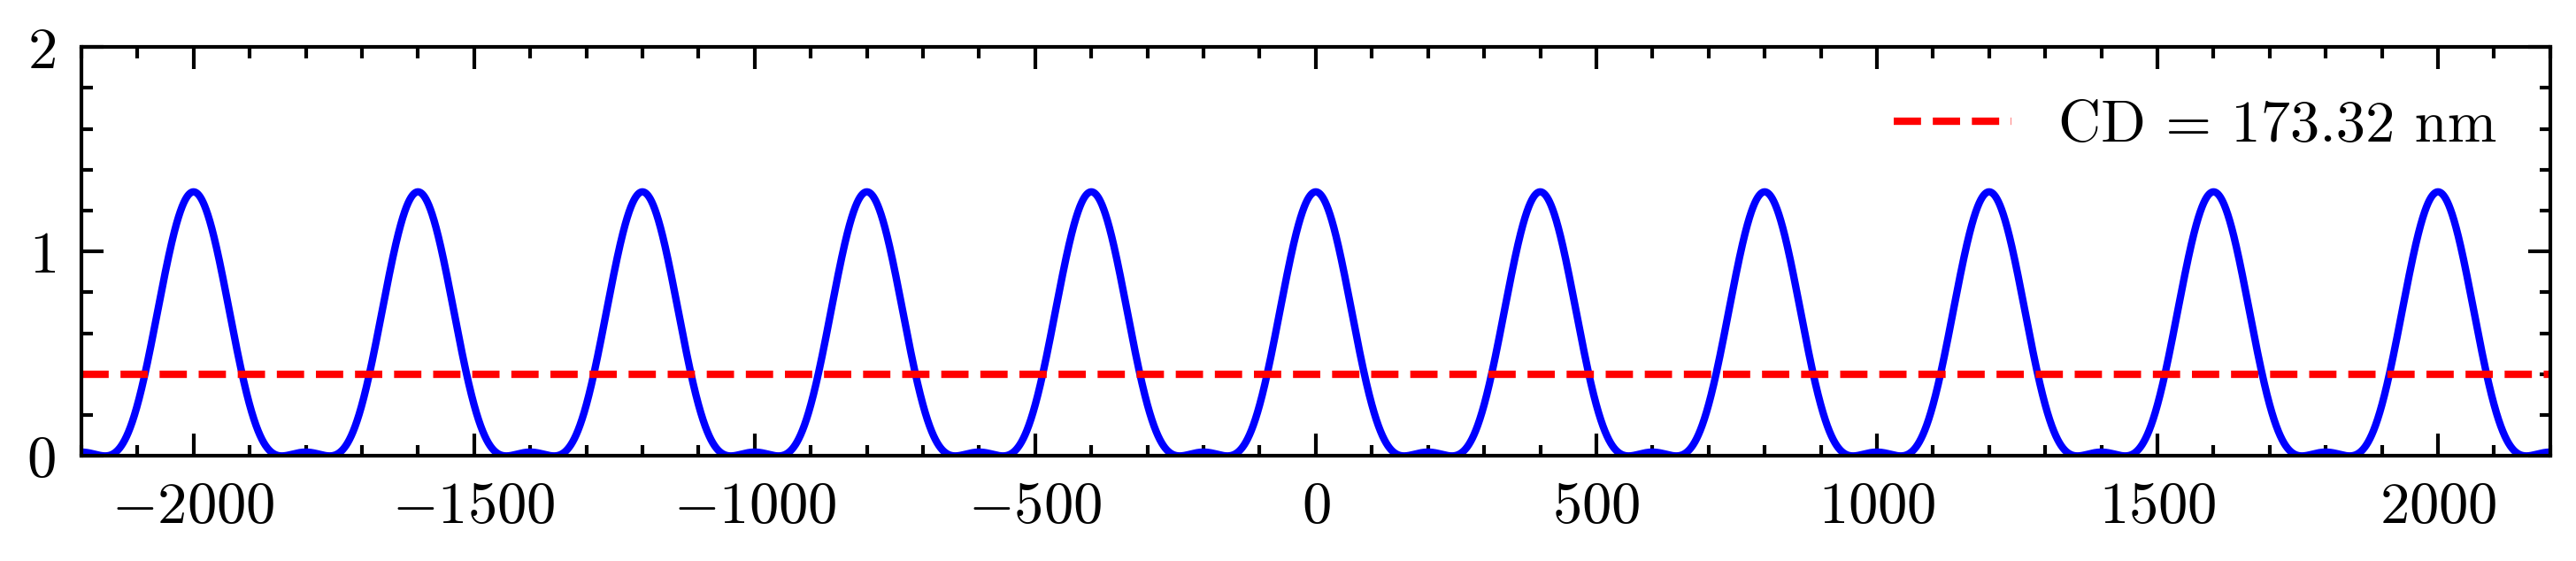

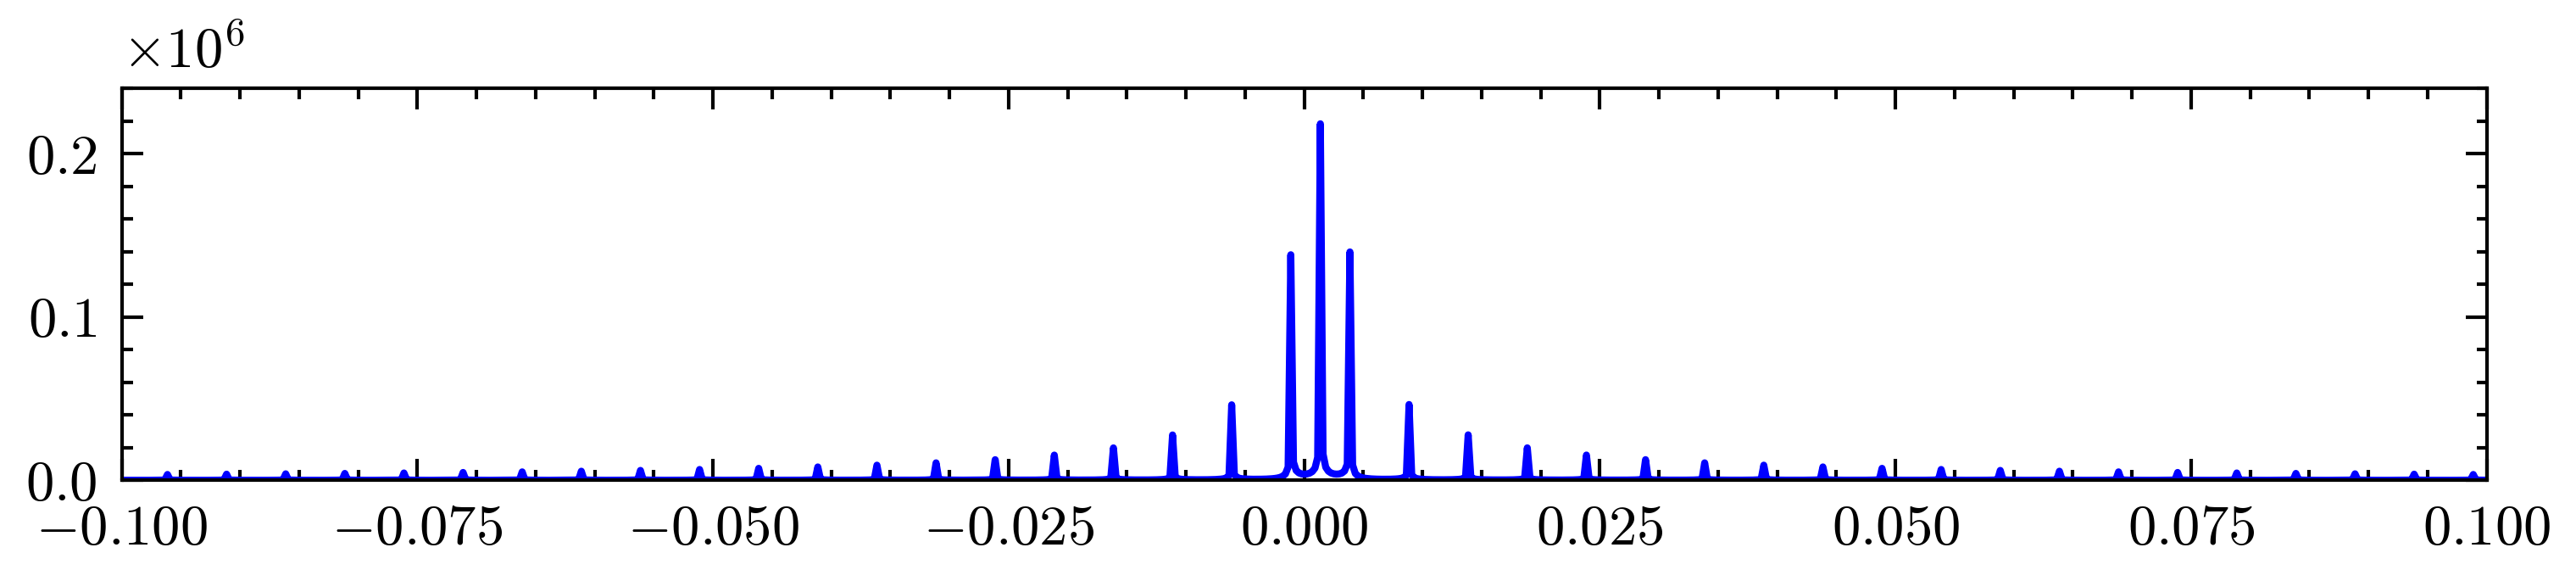

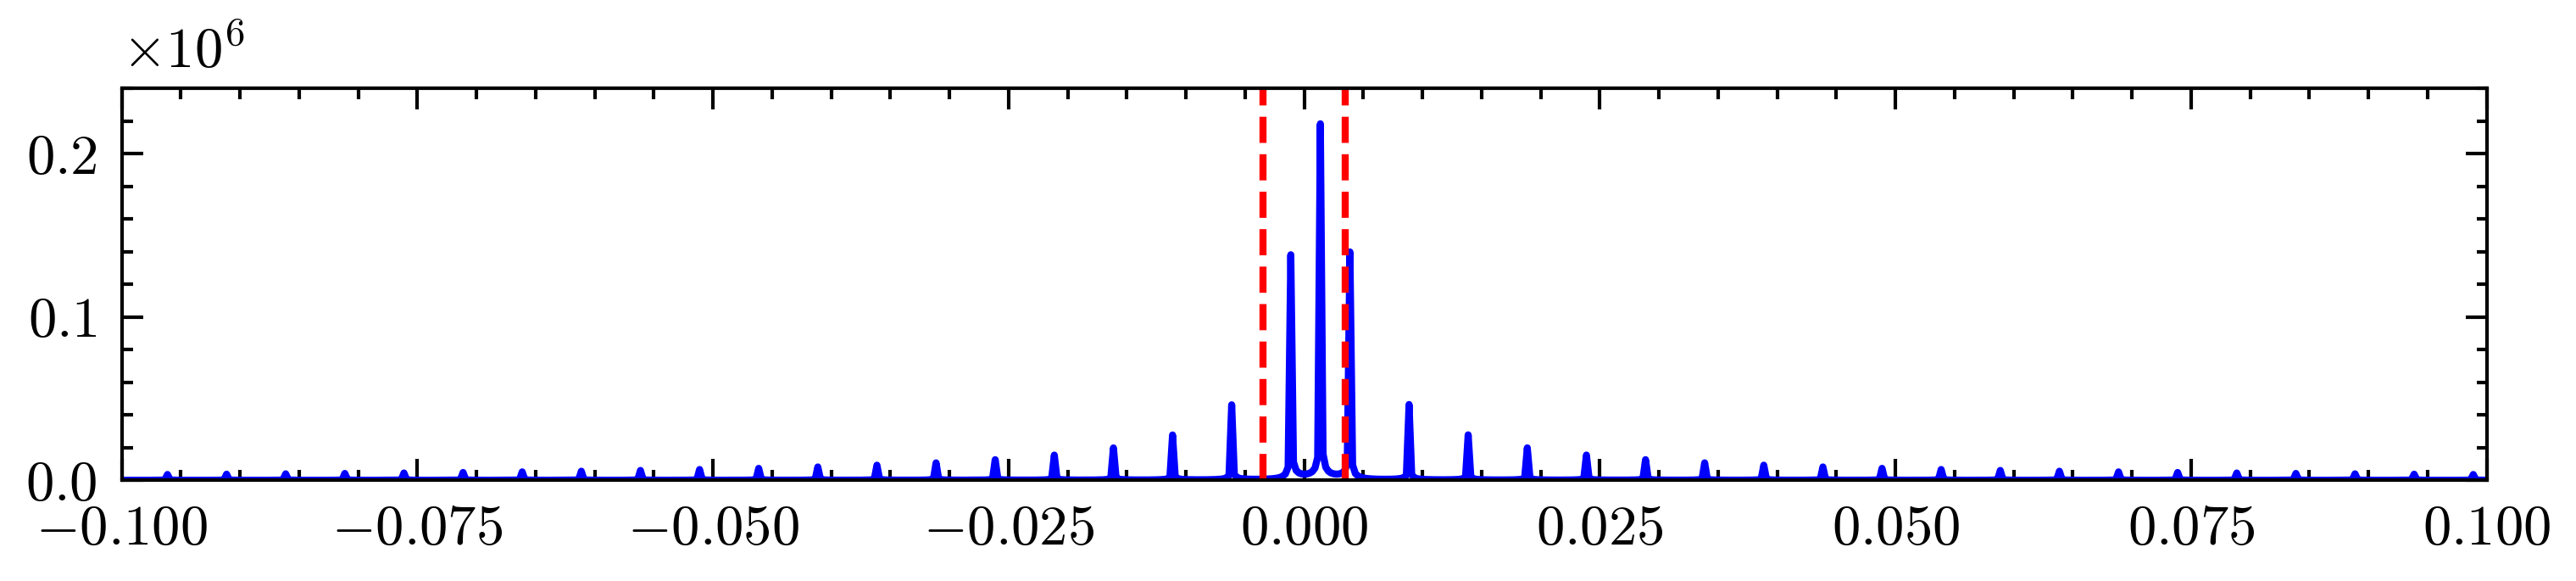

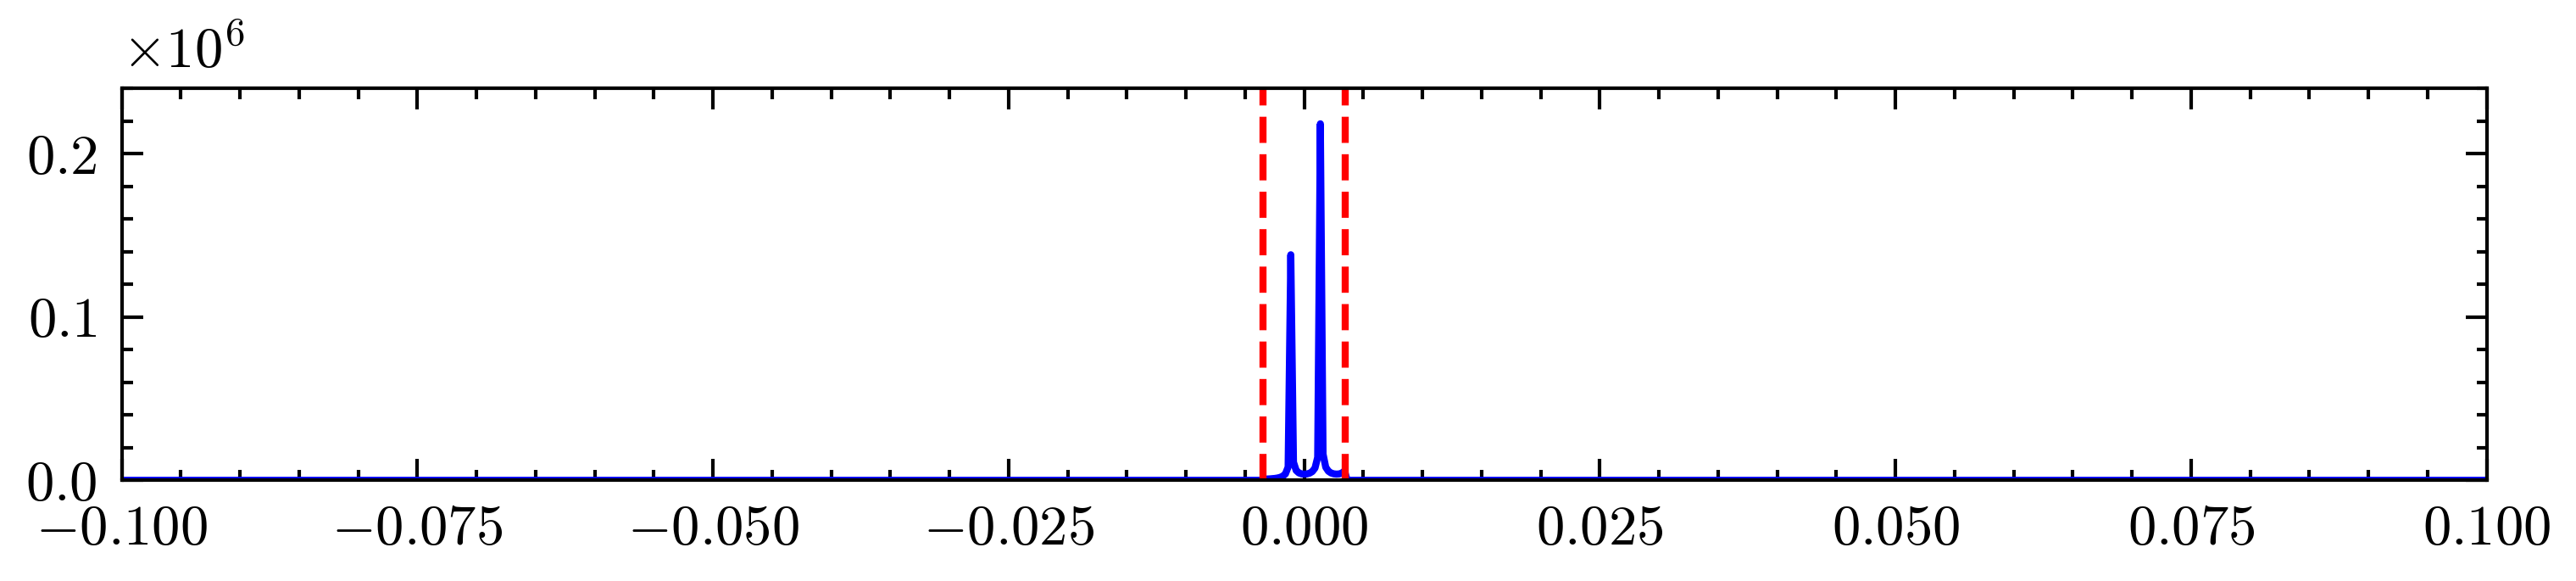

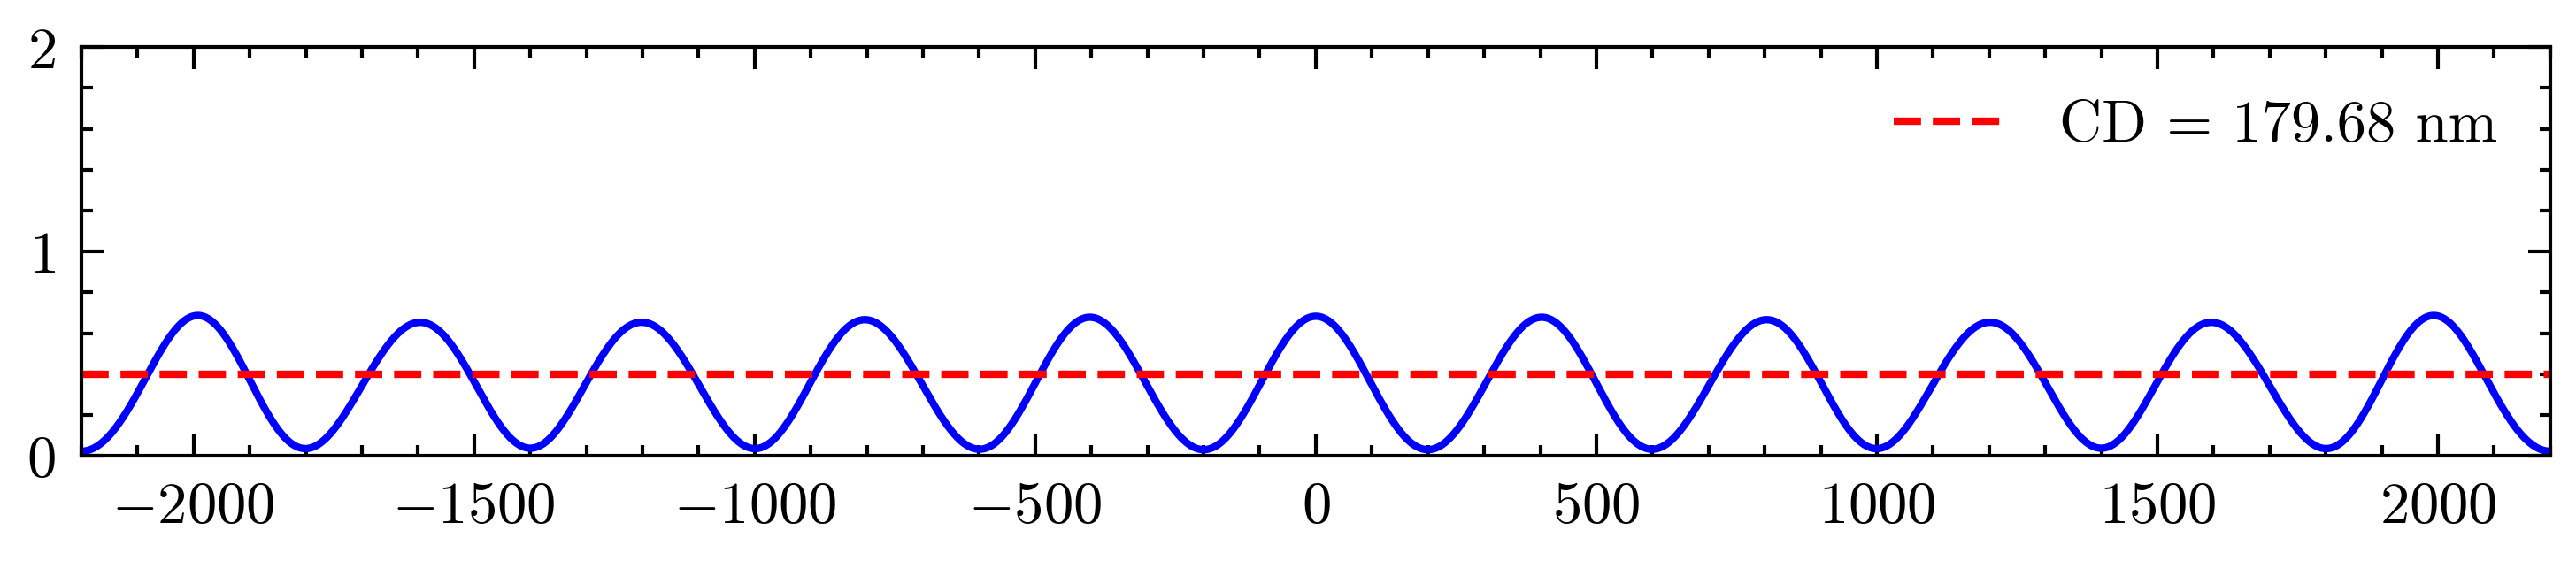

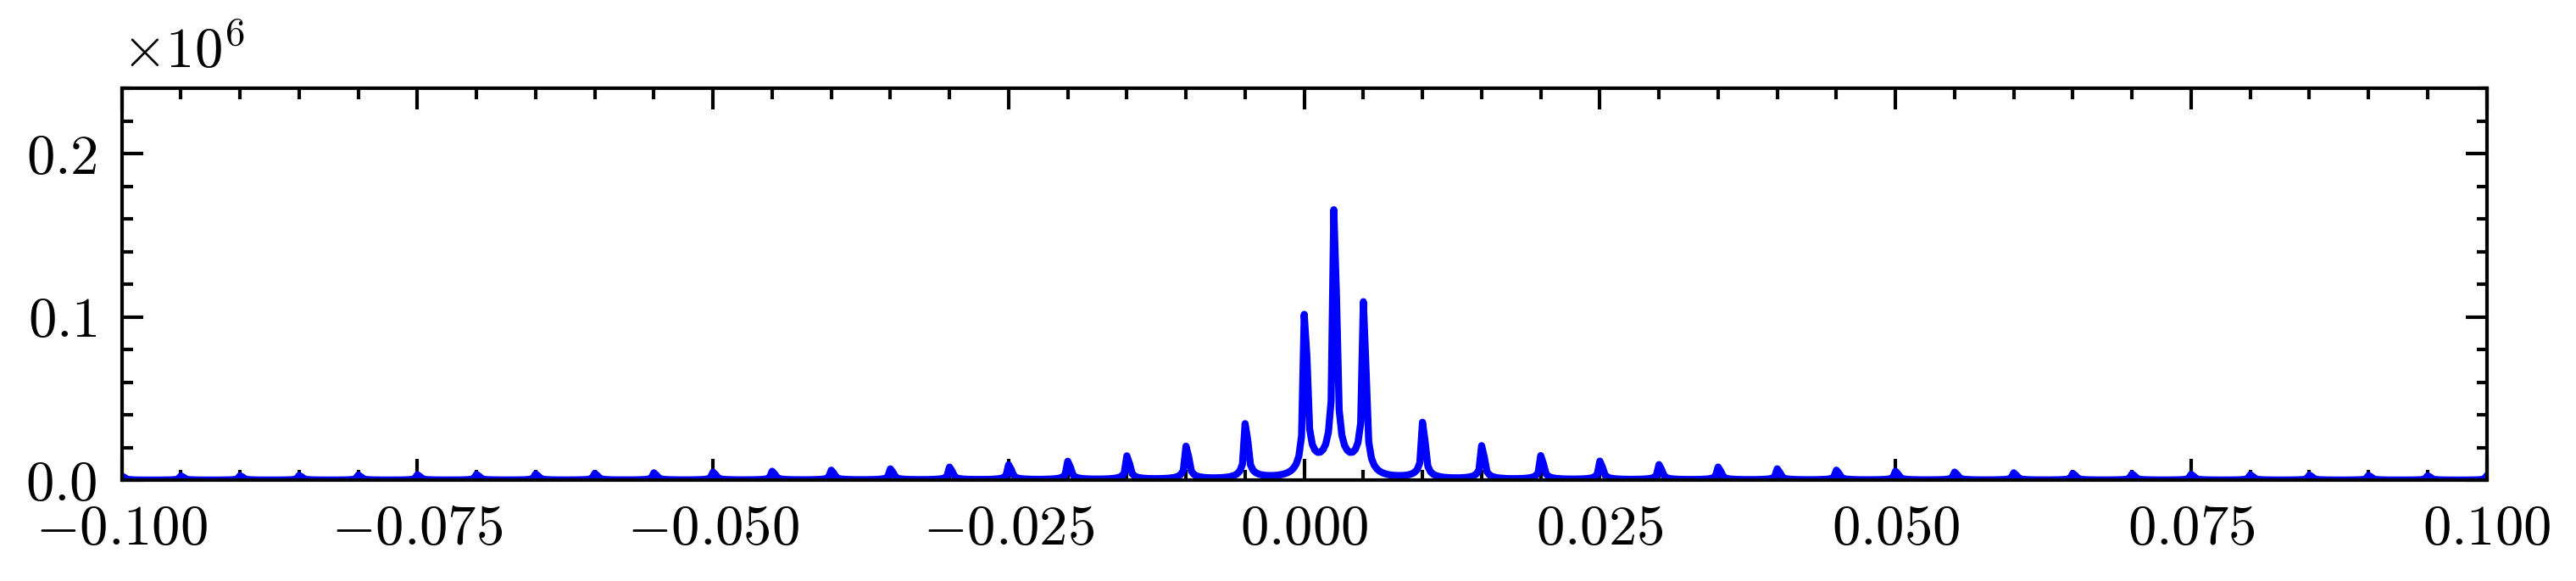

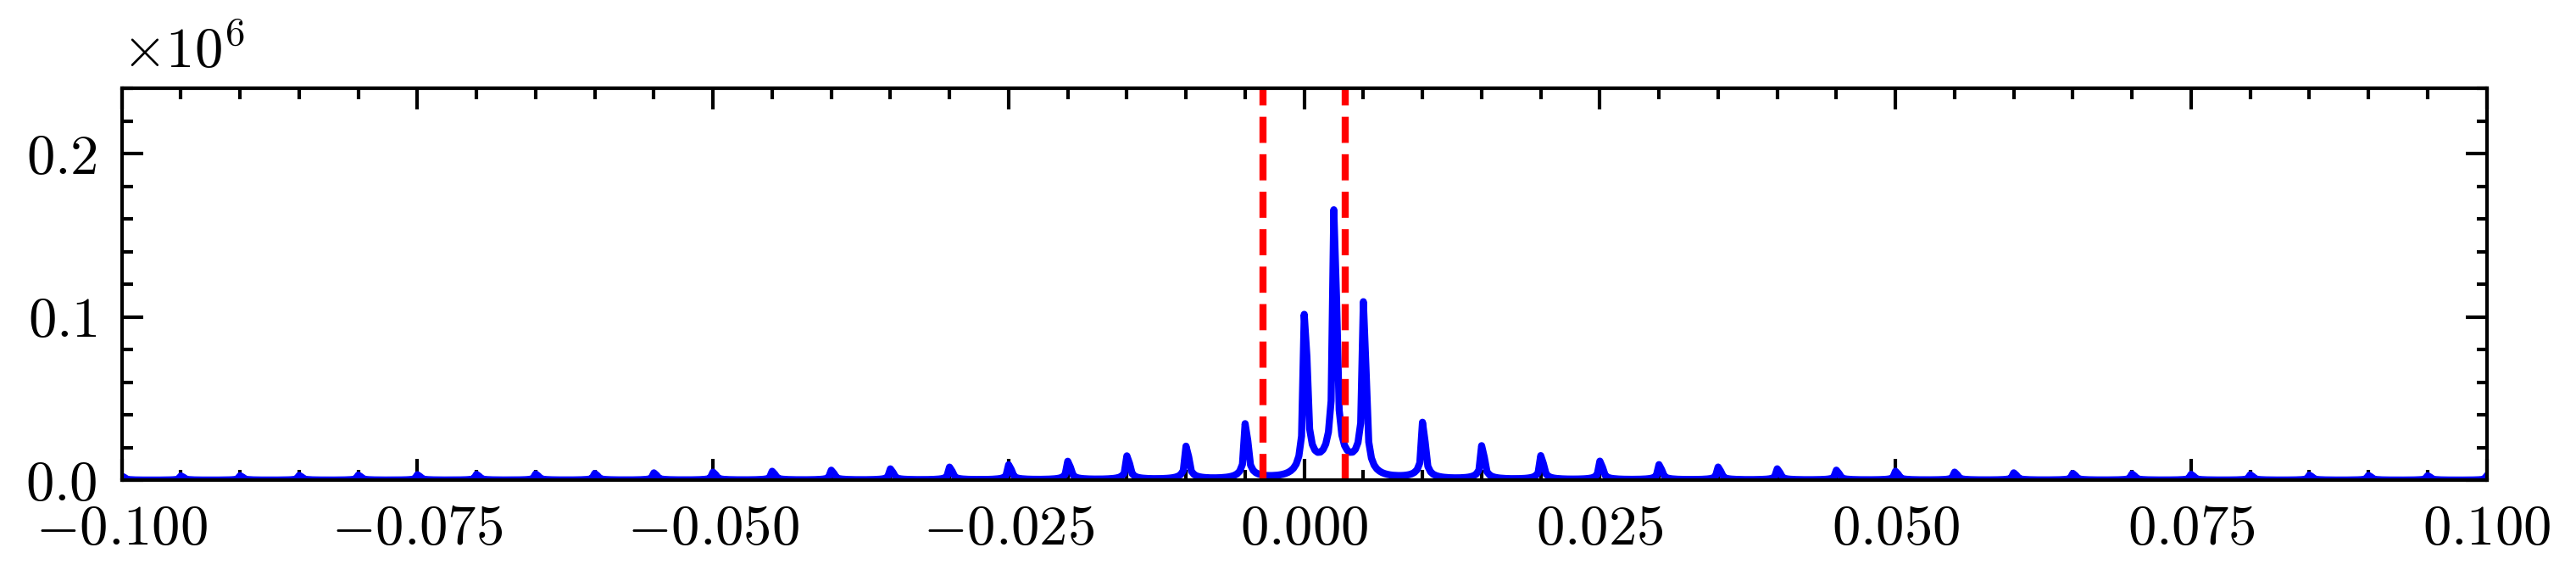

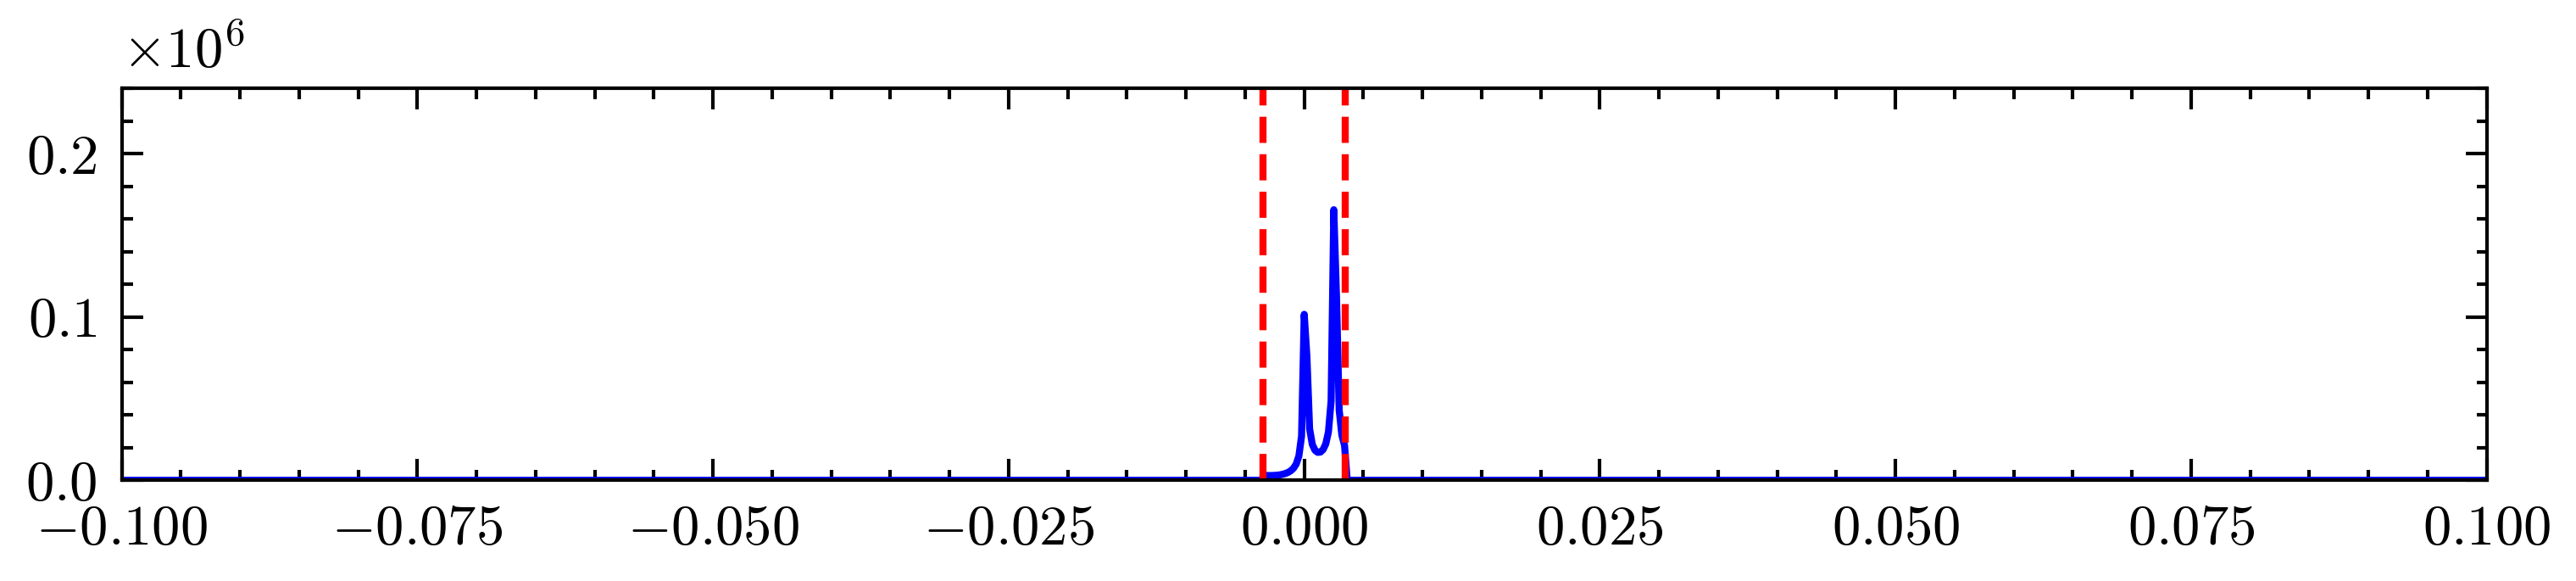

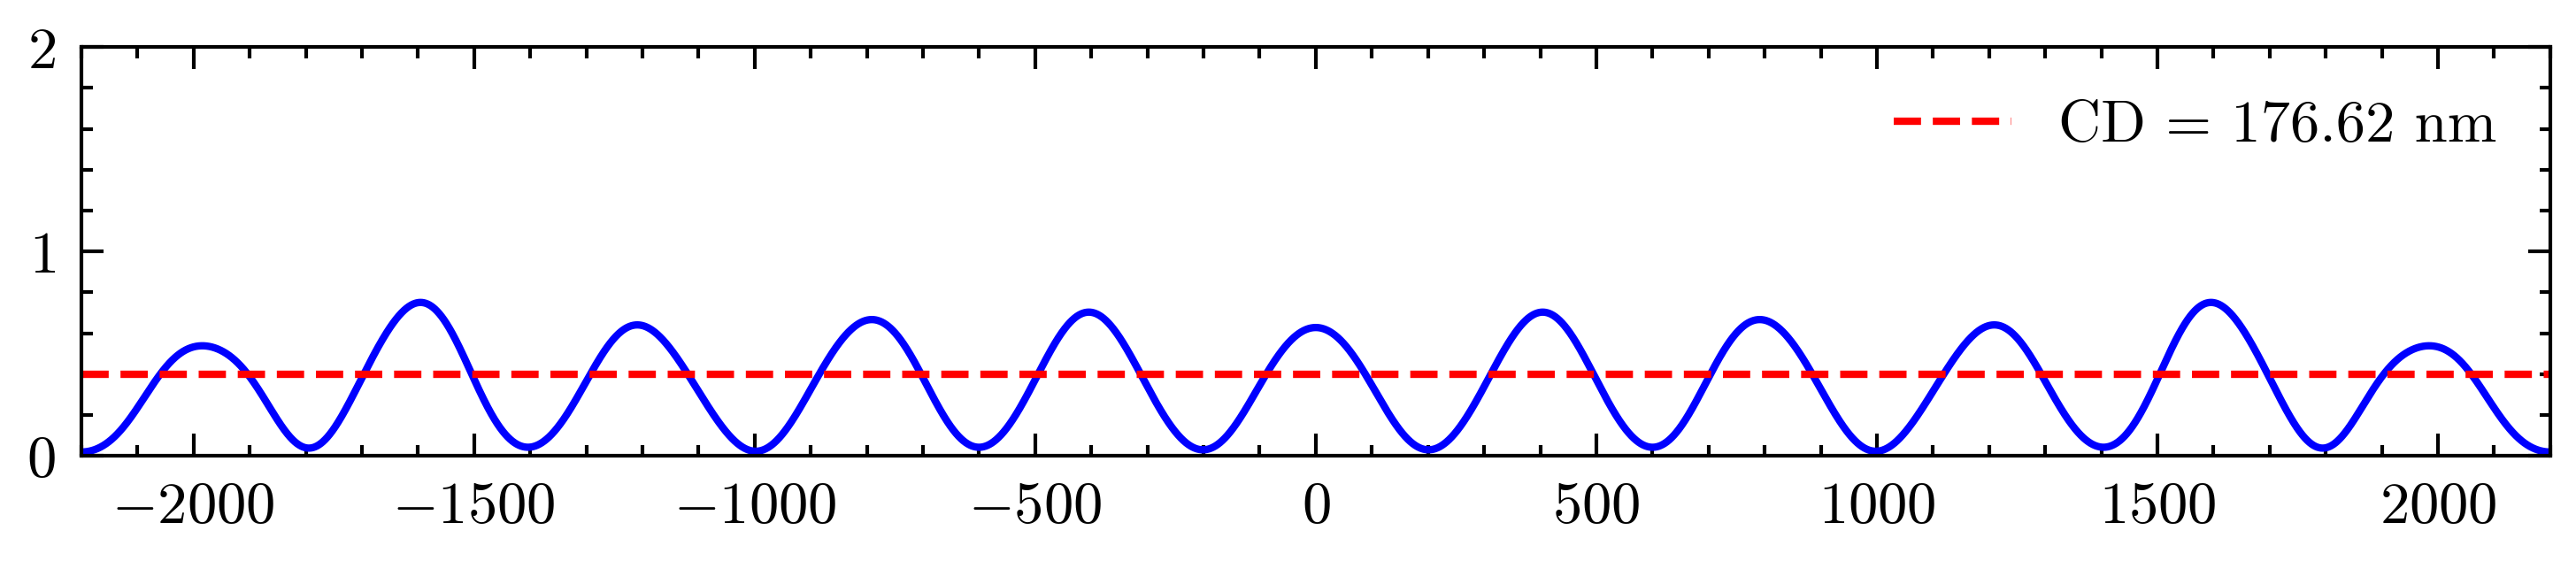

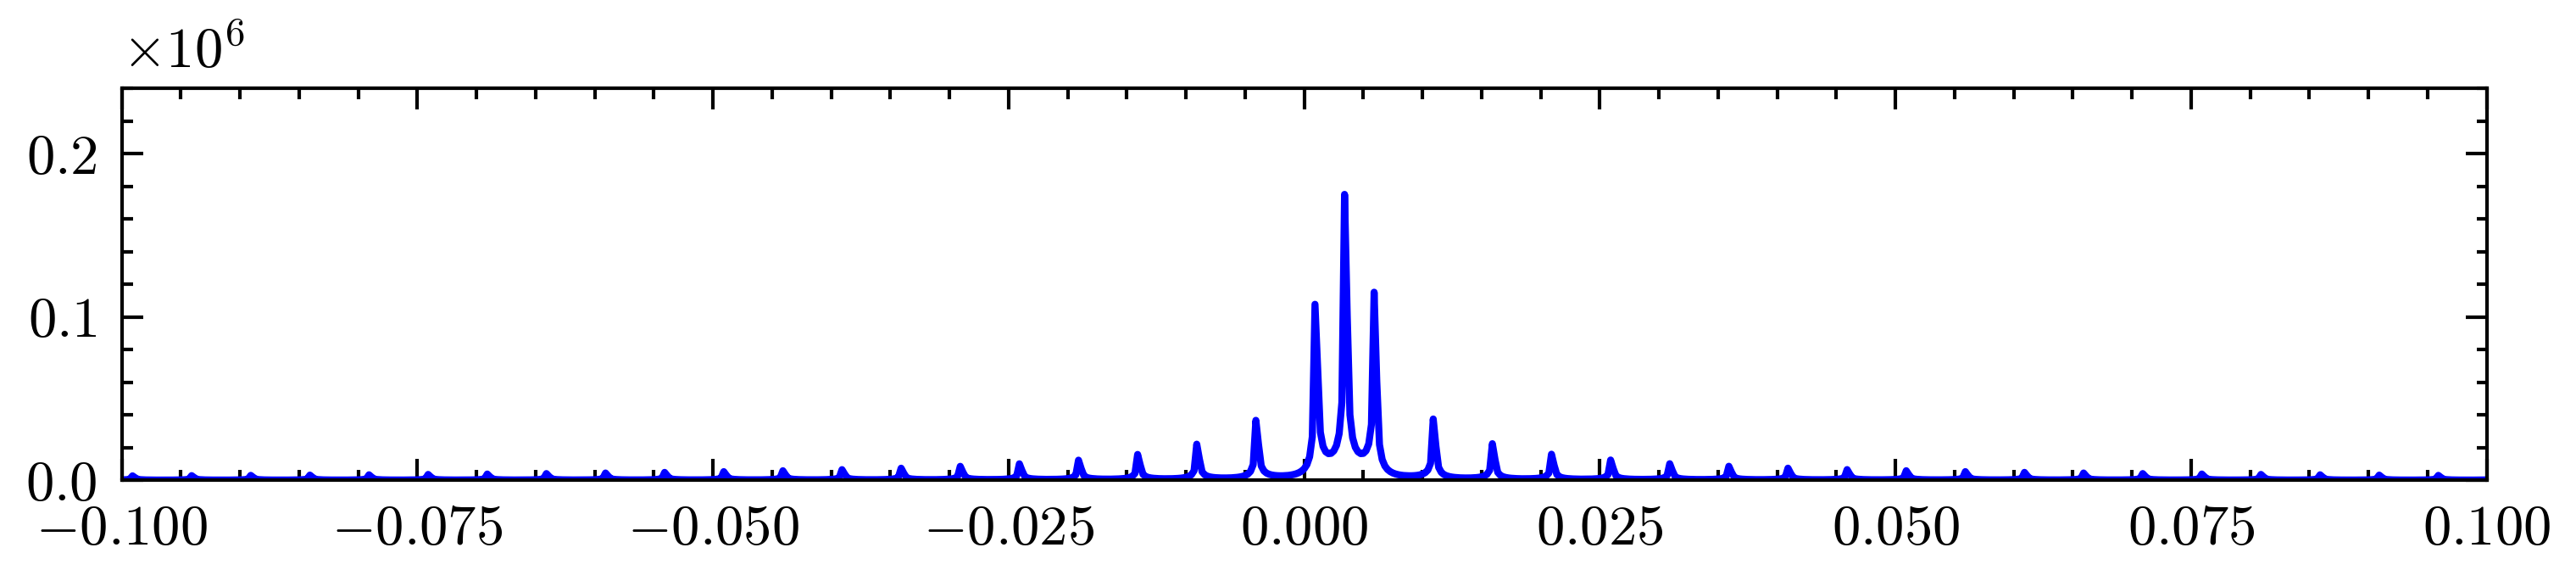

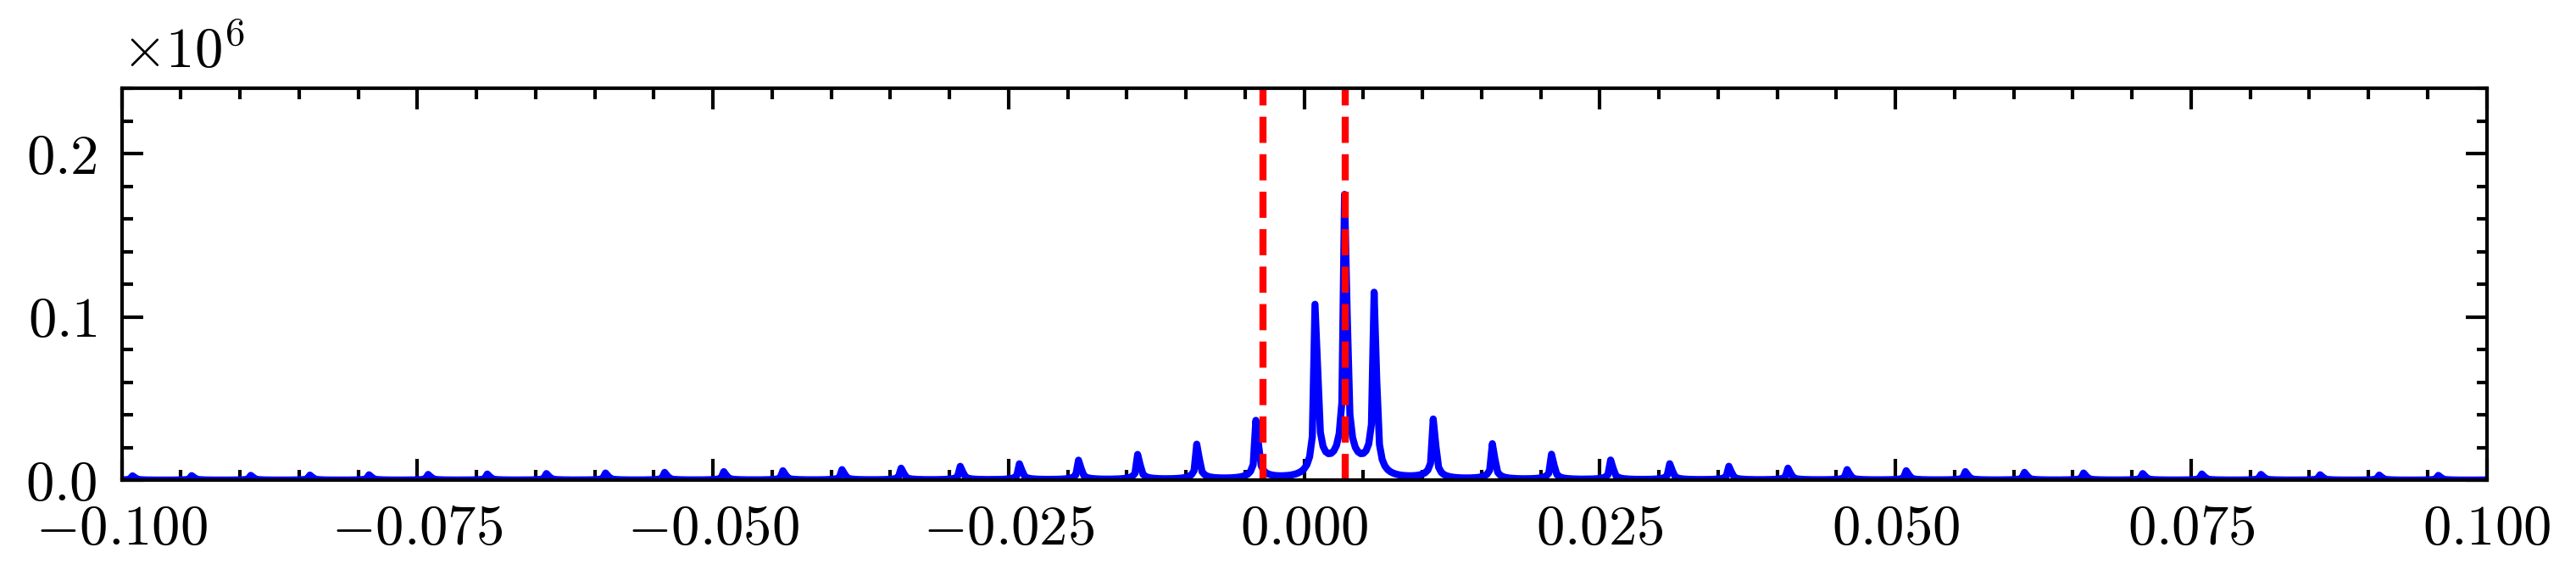

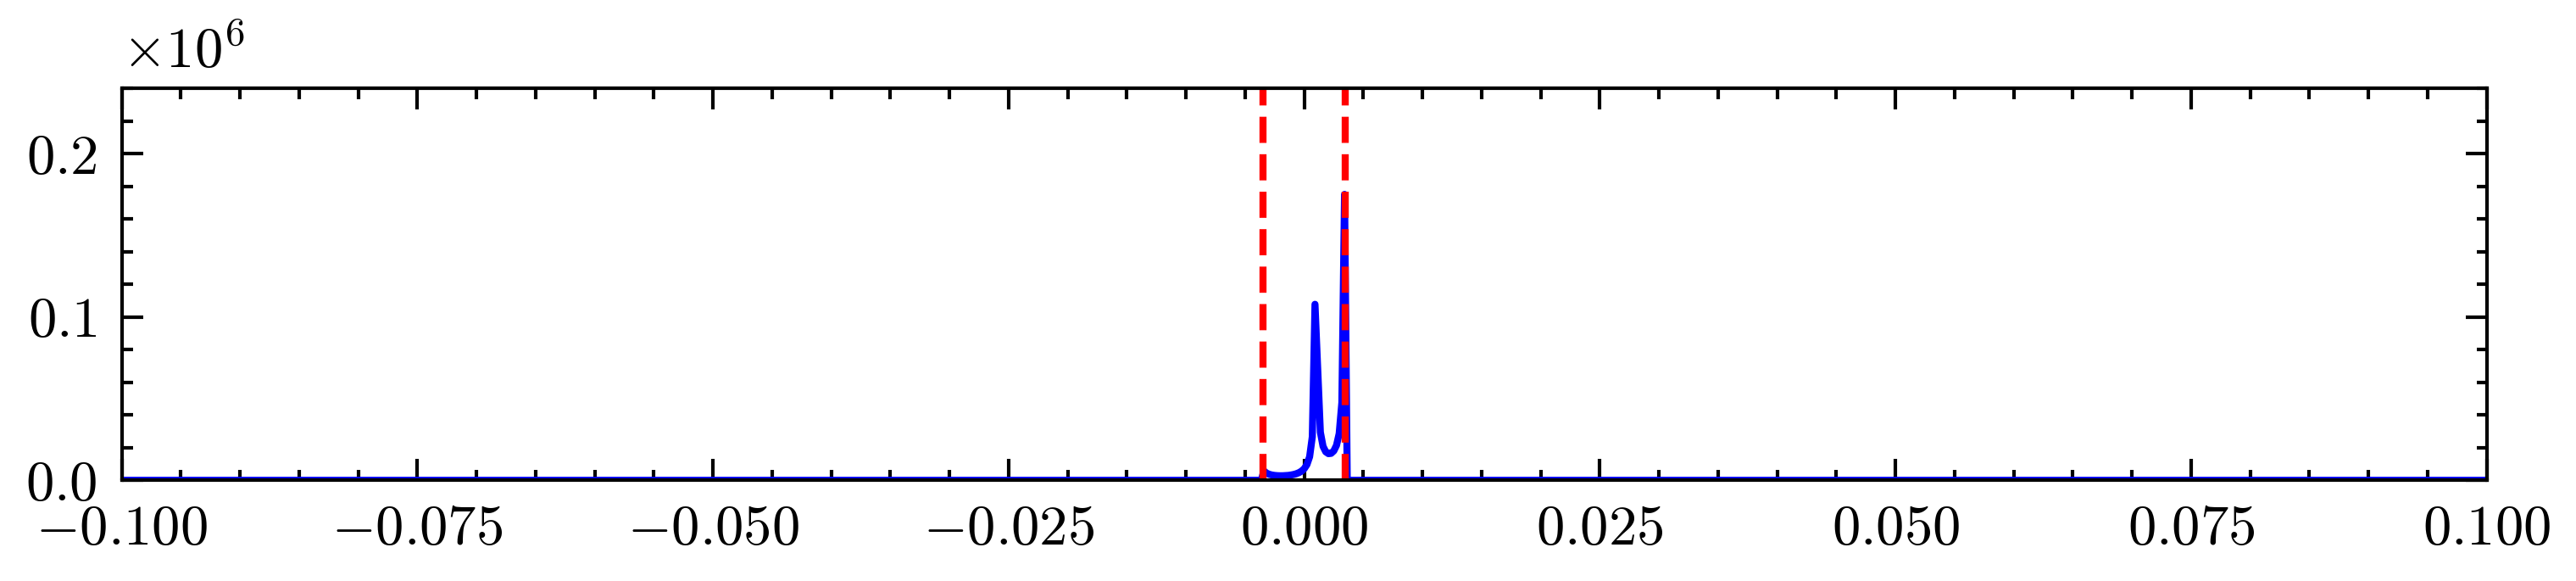

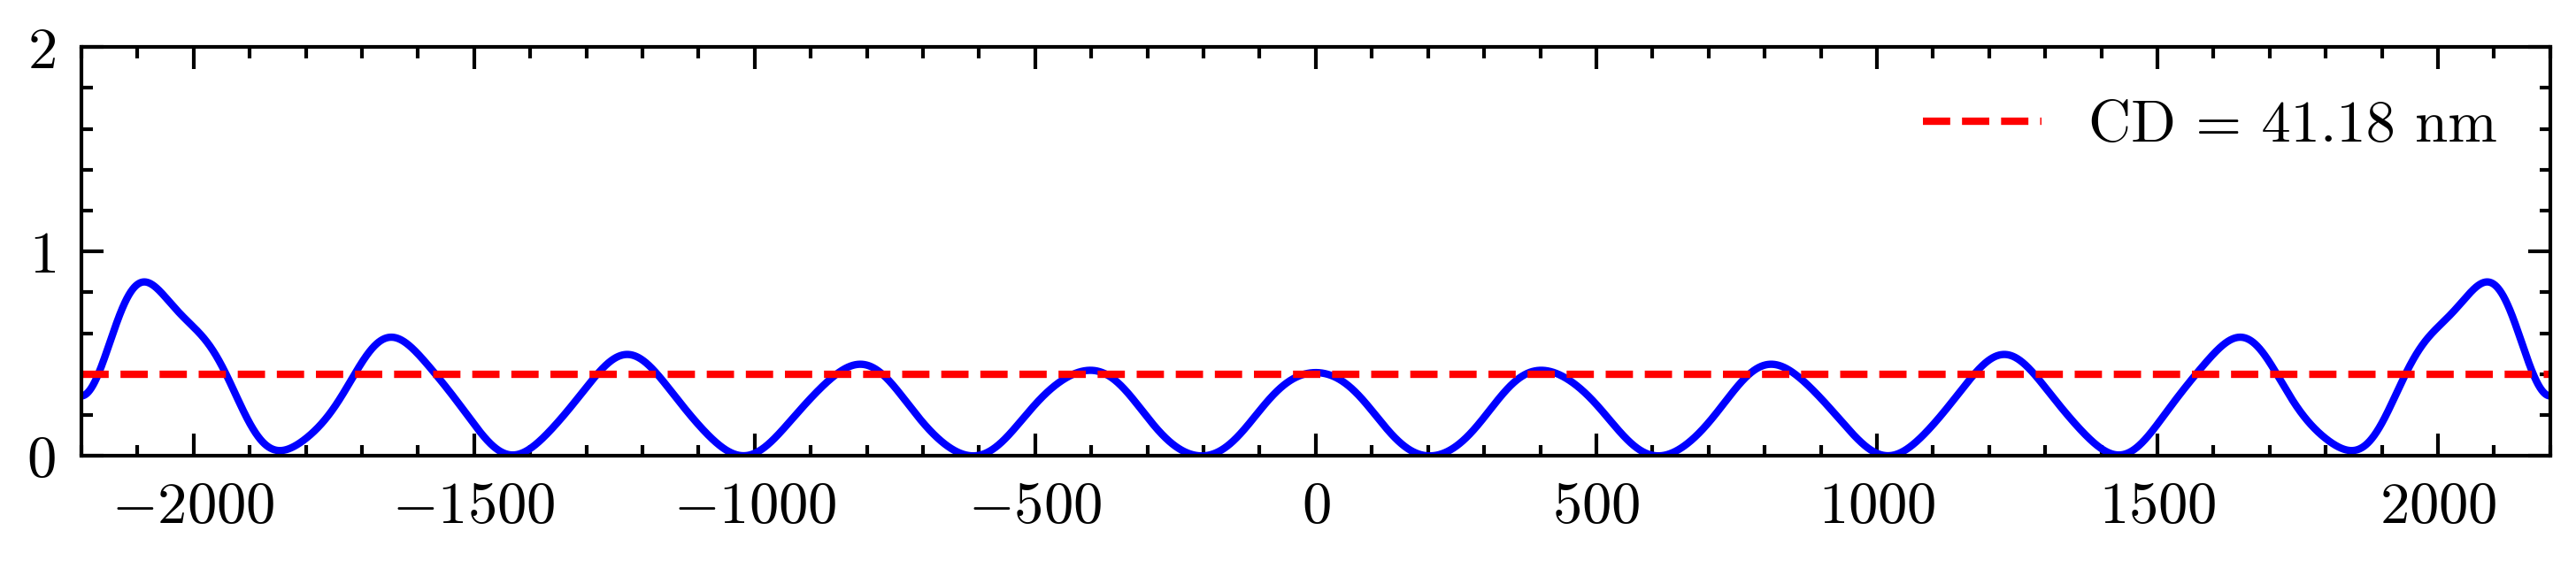

In [8]:
thetas = [0, 20, 40, 60]
magnitude = 1
y_max = 12 * s_dense_width * Fs_dense * magnitude
for angle in thetas:
	# generate Ein
	E_in = generate_Ein(s_dense, angle, magnitude)
	# Ein and the mask
	E_in_mask = np.multiply(E_in, mask_dense)
	# generate Eout
	E_out_unshift = np.fft.fft(E_in_mask)
	# get freq, Eout
	freq, E_out_shift = freq_to_Eout(
		s_dense,
		E_out_unshift,
		Fs_dense
	)

	# condition specified frequency region
	cond = np.abs(freq) <= 0.1
	# plot the frequency to E_out_shift
	plt.figure(figsize=(6, 1))
	plt.xlim(-0.1, 0.1)
	plt.ylim(0, y_max)
	plt.ticklabel_format(
		axis='y', 
		style='sci', 
		scilimits=(6, 6)
	)
	plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
	plt.savefig(f'img_retry/dense_line_FT_{(angle // 20) + 1}')

	# plot the cut-off region before exit pupil
	plt.figure(figsize=(6, 1))
	plt.xlim(-0.1, 0.1)
	plt.ylim(0, y_max)
	plt.ticklabel_format(
		axis='y', 
		style='sci', 
		scilimits=(6, 6)
	)
	plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
	plt.axvline(
		x=-W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.axvline(
		x=W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.savefig(f'img_retry/dense_line_FT_cutoff_{(angle // 20) + 1}')

	# after exit pupil
	E_out_shift_after_exit_pupil = np.where(
		np.abs(freq) <= W, E_out_shift, 0
	)
	# plot the cut-off region after exit pupil
	plt.figure(figsize=(6, 1))
	plt.xlim(-0.1, 0.1)
	plt.ylim(0, y_max)
	plt.ticklabel_format(
		axis='y', 
		style='sci', 
		scilimits=(6, 6)
	)
	plt.plot(freq[cond], np.abs(E_out_shift_after_exit_pupil[cond]), 'b-')
	plt.axvline(
		x=-W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.axvline(
		x=W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.savefig(f'img_retry/dense_line_cutoff_{(angle // 20) + 1}')

	# plot the aerial image
	E_output = np.fft.ifft(E_out_shift_after_exit_pupil)
	I = np.multiply(np.abs(E_output), np.abs(E_output))
	try:
		positive = s_dense[s_dense > 0]
		I_positive = I[s_dense > 0]
		freq_right = np.min(positive[I_positive < THRESHOLD])
		negative = s_dense[s_dense < 0]
		I_negative = I[s_dense < 0]
		freq_left = np.max(negative[I_negative < THRESHOLD])
		CD = freq_right - freq_left
	except ValueError:
		CD = 0
	plt.figure(figsize=(6, 1))
	plt.xlim(-s_dense_space, s_dense_space)
	plt.ylim(0, 2)
	plt.plot(s_dense, I, 'b-')
	plt.axhline(THRESHOLD, color='r', linestyle='--', label=f'CD = {CD:.2f} nm')
	plt.legend()
	plt.savefig(f'img_retry/dense_line_aerial_{(angle // 20) + 1}')